# Load Packages

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import randint, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Model Tuning
import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

import xgboost as xgb
import lightgbm as lgb


from sklearn.ensemble import BaggingClassifier, BaggingRegressor

from sklearn import set_config
# set_config(display='diagram')

import os
import psutil


import warnings
# warnings.filterwarnings('ignore')

# Ignore the warning
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

# Load Data

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png" width=600>

> Data Readme
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

## Load RAW data

In [4]:
pd.options.display.max_columns = 81
pd.options.display.max_rows = 25

In [5]:
# set data source
data_url = 'data/train.csv'

# set index column
index_col = 'Id'

# load data
data = pd.read_csv(data_url, index_col=index_col)
data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


## Feature-Target split

In [6]:
# define the target column in the train dataset
target = 'SalePrice'

# split columns into X and y
X = data.drop(columns = target).copy()
y = data[target]
y_log=np.log(y)

# check the shape of the data
print(f'shape of X is \033[94m{X.shape}\033[0m, shape of y is \033[94m{y.shape}\033[0m')

shape of X is (1460, 79), shape of y is (1460,)


## Missing Values Inspection

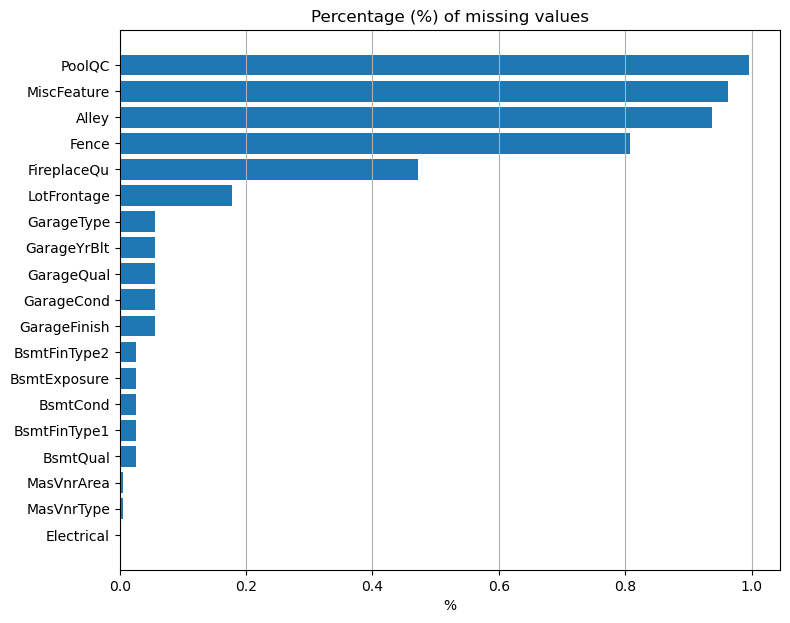

In [6]:
#filter all the features with missing values
feature_null= X.isnull().mean().sort_values(ascending = False)
feature_null=feature_null[feature_null>0]

# visualize
plt.figure(figsize=(8, feature_null.shape[0]/3))
feature_ranks = range(len(feature_null))
bar = plt.barh(feature_null.index, feature_null.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Percentage (%) of missing values")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

# features have large % of missing values should be considerred DROP

In [7]:
# Fillna() based on the data descriptions

X.MiscFeature.fillna('NA', inplace=True) #[NA, 'Shed', 'Gar2', 'Othr', 'TenC']
X.Alley.fillna('NA', inplace=True) #[None, 'Grvl', 'Pave']
X.Fence.fillna('NA', inplace=True) #[NA, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw']
X.GarageType.fillna('NA', inplace=True) #['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'None', 'Basment', '2Types']
X.GarageFinish.fillna('NA', inplace=True) #['NA', Unf', RFn', ''Fin']

X.PoolQC.fillna('NA', inplace=True)       # ['NA', 'Fa', 'Gd', 'Ex']
X.FireplaceQu.fillna('NA', inplace=True)  # ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
X.GarageQual.fillna('NA', inplace=True)   # ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
X.GarageCond.fillna('NA', inplace=True)   # ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
X.BsmtCond.fillna('NA', inplace=True)     # ['NA', 'Po', 'Fa', 'TA', 'Gd'])
X.BsmtQual.fillna('NA', inplace=True)     # ['NA', 'Fa', 'TA', 'Gd', 'Ex']
X.BsmtExposure.fillna('NA', inplace=True) # ['NA', 'No', 'Gd', 'Mn', 'Av', nan]
X.BsmtFinType2.fillna('NA', inplace=True) # ['NA', 'Unf', 'LwQ', 'BLQ', ALQ', 'Rec', 'GLQ']
X.BsmtFinType1.fillna('NA', inplace=True) # ['NA', 'Unf', 'LwQ', 'BLQ', ALQ', 'Rec','GLQ']
X.GarageYrBlt.fillna(0, inplace=True)

# Drop rows
# X.MasVnrArea.isnull().sum()
X.dropna(subset=['MasVnrArea'], inplace=True)
# X.MasVnrType.isnull().sum()
X.dropna(subset=['MasVnrType'], inplace=True)
X.Electrical.isnull().sum()
X.dropna(subset=['Electrical'], inplace=True)

In [8]:
# Fill Na for LotFrontage by using the most relevant features
from sklearn.linear_model import LinearRegression

top3 = X[['1stFlrSF', 'LotArea', 'MSSubClass']] 

# Create and fit the linear regression model
regression_model = LinearRegression()
regression_model.fit(top3[X.LotFrontage.notna()], X.LotFrontage[X.LotFrontage.notna()])

# Predict the target variable using the same features
null_rows = X.LotFrontage.isnull()
X.LotFrontage[null_rows] = regression_model.predict(top3)[null_rows]

In [9]:
X.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

## Feature Selection

In [24]:
X = data.drop(columns = target).copy()
features_all = X.columns.sort_values().to_list()

features_to_drop = [

    #highly unbalanced numerical feature
    '3SsnPorch', 'BsmtFinSF2','BsmtHalfBath', 'EnclosedPorch','KitchenAbvGr', 
    'LowQualFinSF', 'MiscVal', 'PoolArea', 'ScreenPorch', 
    
#     'BsmtFullBath', 'Fireplaces', 'FullBath', 'GarageCars', 
#     'GarageYrBlt','HalfBath',  'MoSold', 'OverallCond', 
#     'OverallQual', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 
#     'YrSold',
    
    #highly unbalanced categorical feature
    'Condition2', 'Functional', 'GarageCond',  'GarageQual', 'Heating',
    'LandSlope','RoofMatl', 'Street', 'Utilities', 
    
    #categorical feature which may create many OneHotEncoder columns
#     'Exterior1st', 'Exterior2nd', 'Neighborhood', 'SaleType', 'Condition1','BldgType', 
#    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical'
    
    #dropped all non oridinal features???
#     'Foundation', 'GarageFinish', 'GarageType', 'HouseStyle', 'LandContour', 'LotConfig', 
#     'LotShape', 'MSZoning', 'MasVnrType', 'PavedDrive', 'RoofStyle', 'SaleCondition'
]
# features_to_drop = []
X = X.drop(columns=features_to_drop)

feature_numerical = X.select_dtypes(exclude='object').columns.sort_values().to_list()

# Numerical features following uniform distrution
feature_numerical_norm = ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 
                          'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']
# feature_numerical_norm = []

feature_numerical_uniform = [key for key in feature_numerical 
                              if key not in feature_numerical_norm]

feature_categorical = X.select_dtypes(include='object').columns.sort_values().to_list()

feat_ordinal_dict = { # considers "NA" as the worse category
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['NA', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Functional": ['NA', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
#     "GarageCond": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['NA', 'Unf', 'RFn', 'Fin'],
#     "GarageQual": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
#     "LandContour": ['NA', 'Low', 'Bnk', 'HLS', 'Lvl'],
#     "LandSlope": ['NA', 'Sev', 'Mod', 'Gtl'],
#     "LotShape": ['NA', 'IR3', 'IR2', 'IR1', 'Reg'],
#     "PavedDrive": ['NA', 'N', 'P', 'Y'],
    "PoolQC": ['NA', 'Fa', 'Gd', 'Ex'],
}

feature_categorical_Ordinal = list(feat_ordinal_dict.keys())
feature_categorical_ordinal_values = list(feat_ordinal_dict.values())

# feature_categorical_Ordinal.sort()

feature_categorical_OneHot = [key for key in feature_categorical 
                              if key not in feature_categorical_Ordinal]

print('--------OVERVIEW----------')

print(f'All features (\033[95m{len(features_all)}\
\033[0m): \033[94m{features_all}\033[0m')

print(f'Features to drop (\033[91m{len(features_to_drop)}\
\033[0m): \033[94m{features_to_drop}\033[0m')

print('--------CATEGORICAL----------')

print(f'Categorical cat features (\033[95m{len(feature_categorical)}\
\033[0m): \033[94m{feature_categorical}\033[0m')

print(f'Ordinal cat features (\033[95m{len(feature_categorical_Ordinal)}\
\033[0m): \033[94m{feature_categorical_Ordinal}\033[0m')

print(f'None-ordinal cat features (\033[95m{len(feature_categorical_OneHot)}\
\033[0m): \033[94m{feature_categorical_OneHot}\033[0m')

print('---------NUMERICAL---------')

print(f'Numerical features (\033[95m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

print(f'Numerical features (\033[95m{len(feature_numerical_norm)}\
\033[0m): \033[94m{feature_numerical_norm}\033[0m')

print(f'Numerical features (\033[95m{len(feature_numerical_uniform)}\
\033[0m): \033[94m{feature_numerical_uniform}\033[0m')

--------OVERVIEW----------
All features (79): ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleTyp

# Data Exploration

## Distribution of each numerical feature

In [77]:
print(f'Numerical features (\033[94m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m') 

Numerical features (27): ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtUnfSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'LotArea', 'LotFrontage', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


Numerical features (19): ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFullBath', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'HalfBath', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


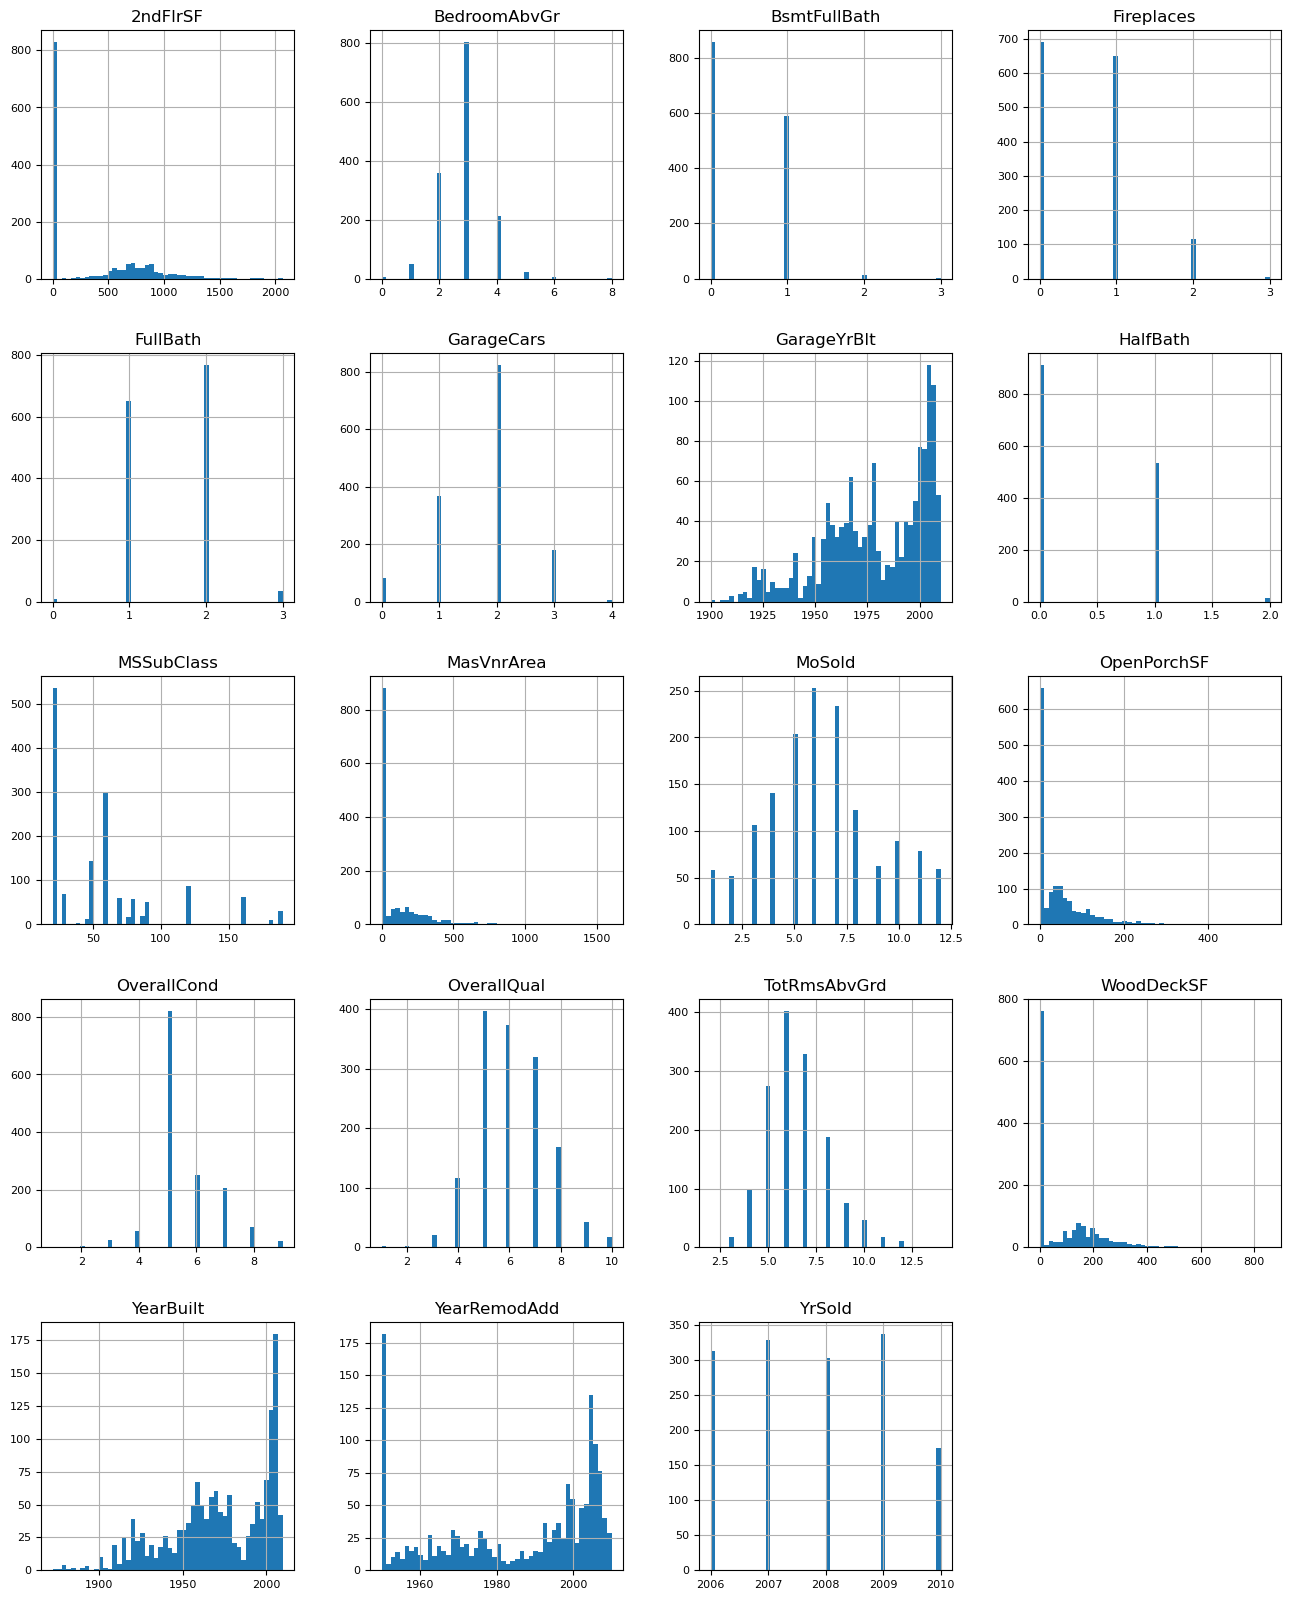

In [33]:
print(f'Numerical features (\033[94m{len(feature_numerical_uniform)}\
\033[0m): \033[94m{feature_numerical_uniform}\033[0m')
X[feature_numerical_uniform].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

Numerical features (8): ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF']


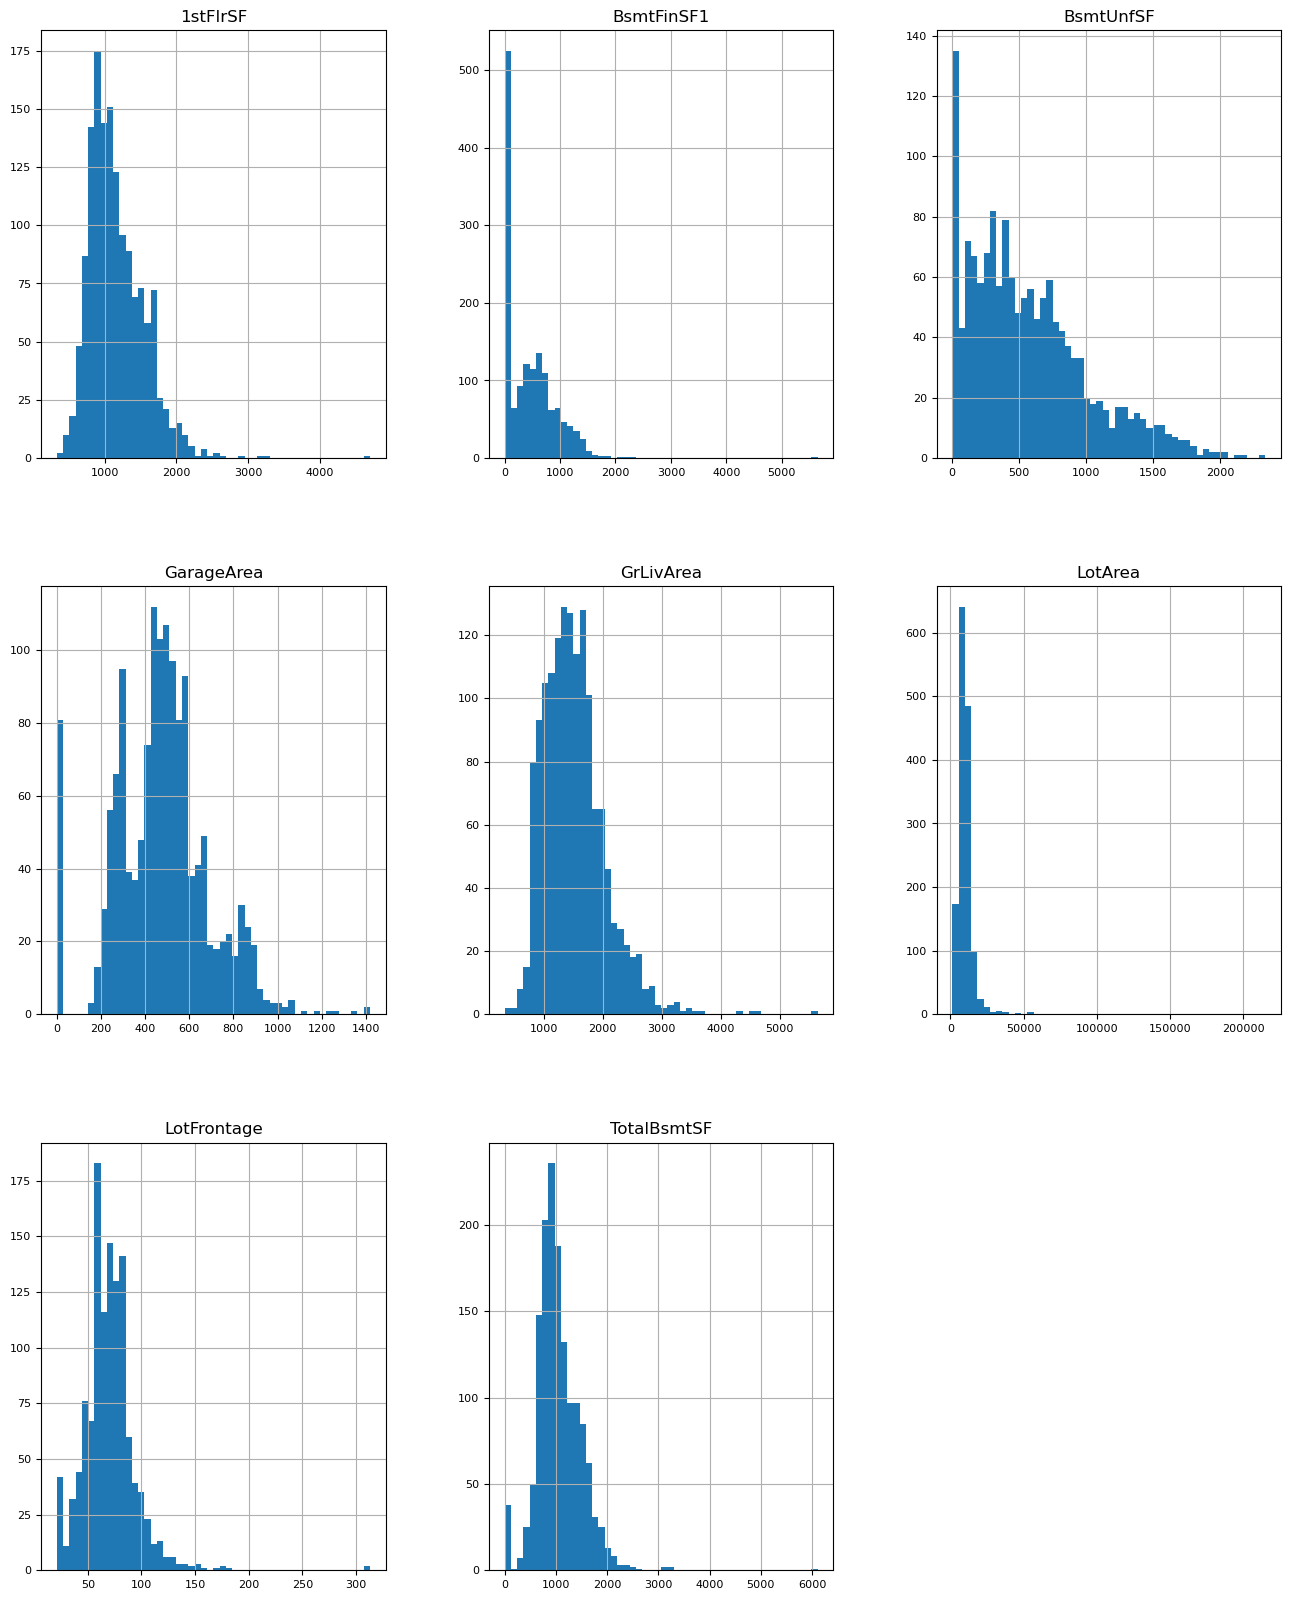

In [34]:
print(f'Numerical features (\033[94m{len(feature_numerical_norm)}\
\033[0m): \033[94m{feature_numerical_norm}\033[0m')

X[feature_numerical_norm].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

<Axes: >

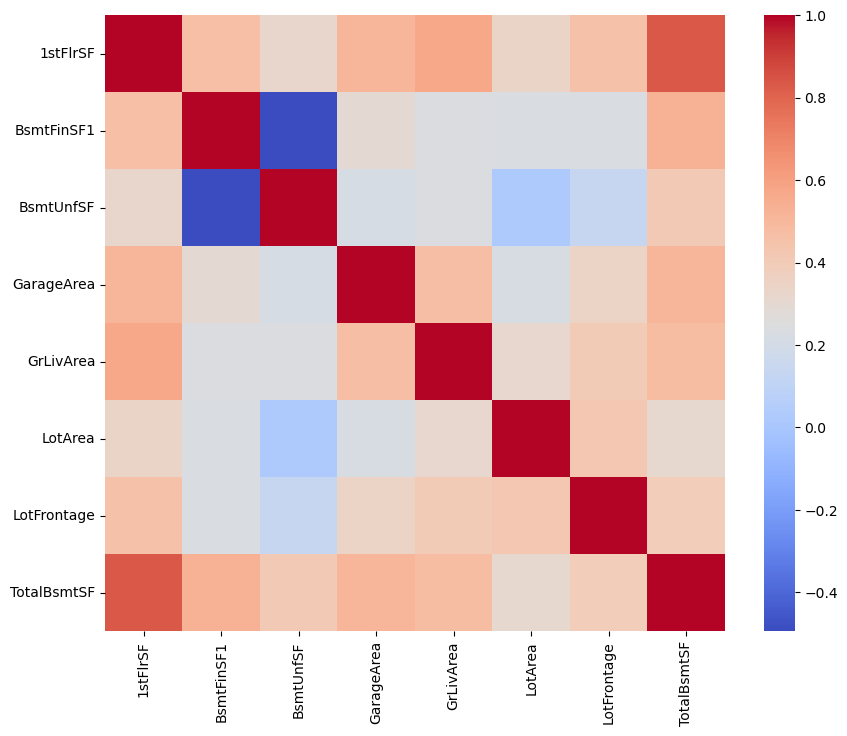

In [35]:
X_num = X[feature_numerical_norm].dropna()

# figsize
plt.figure(figsize=(10,8))
sns.heatmap(X_num.corr(), cmap='coolwarm')

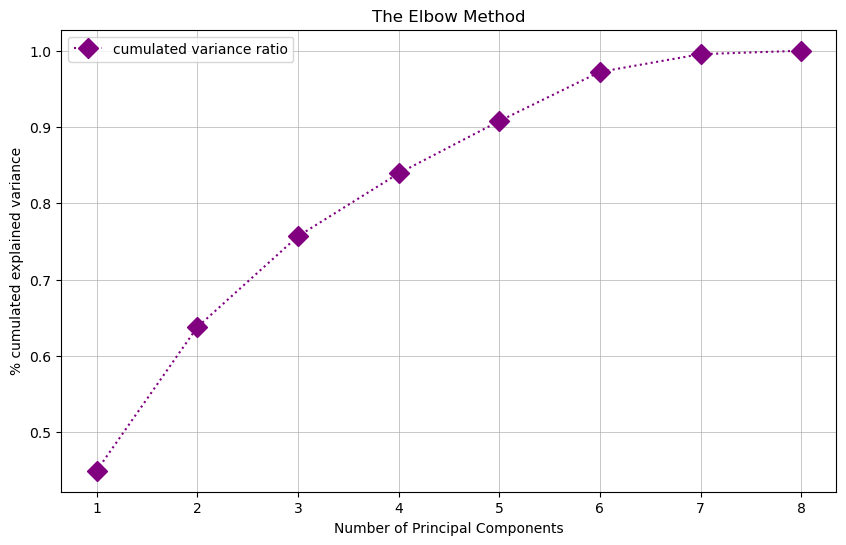

In [36]:
pca = PCA()
X_scaled = StandardScaler().fit_transform(X_num)
X_pca = pca.fit_transform(X_scaled)

with plt.style.context('seaborn-deep'):
    
    # figsize
    plt.figure(figsize=(10,6))
    
    # getting axes
    ax = plt.gca()
    
    # plotting
    evr_cumulated = np.cumsum(pca.explained_variance_ratio_)
    x_axis_ticks = np.arange(1,evr_cumulated.shape[0]+1)
    ax.plot(x_axis_ticks,evr_cumulated,label="cumulated variance ratio",
            color="purple",linestyle=":",marker="D",markersize=10)
    
    
    # customizing
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('% cumulated explained variance')
    ax.legend(loc="upper left")
    ax.set_title('The Elbow Method')
    ax.set_xticks(x_axis_ticks)
#     ax.scatter(15,evr_cumulated[15-1],c='blue',s=400)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

## Distribution of each catigorical feature

Categorical cat features (28): ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Foundation', 'GarageFinish', 'GarageType', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'PavedDrive', 'PoolQC', 'RoofStyle', 'SaleCondition']


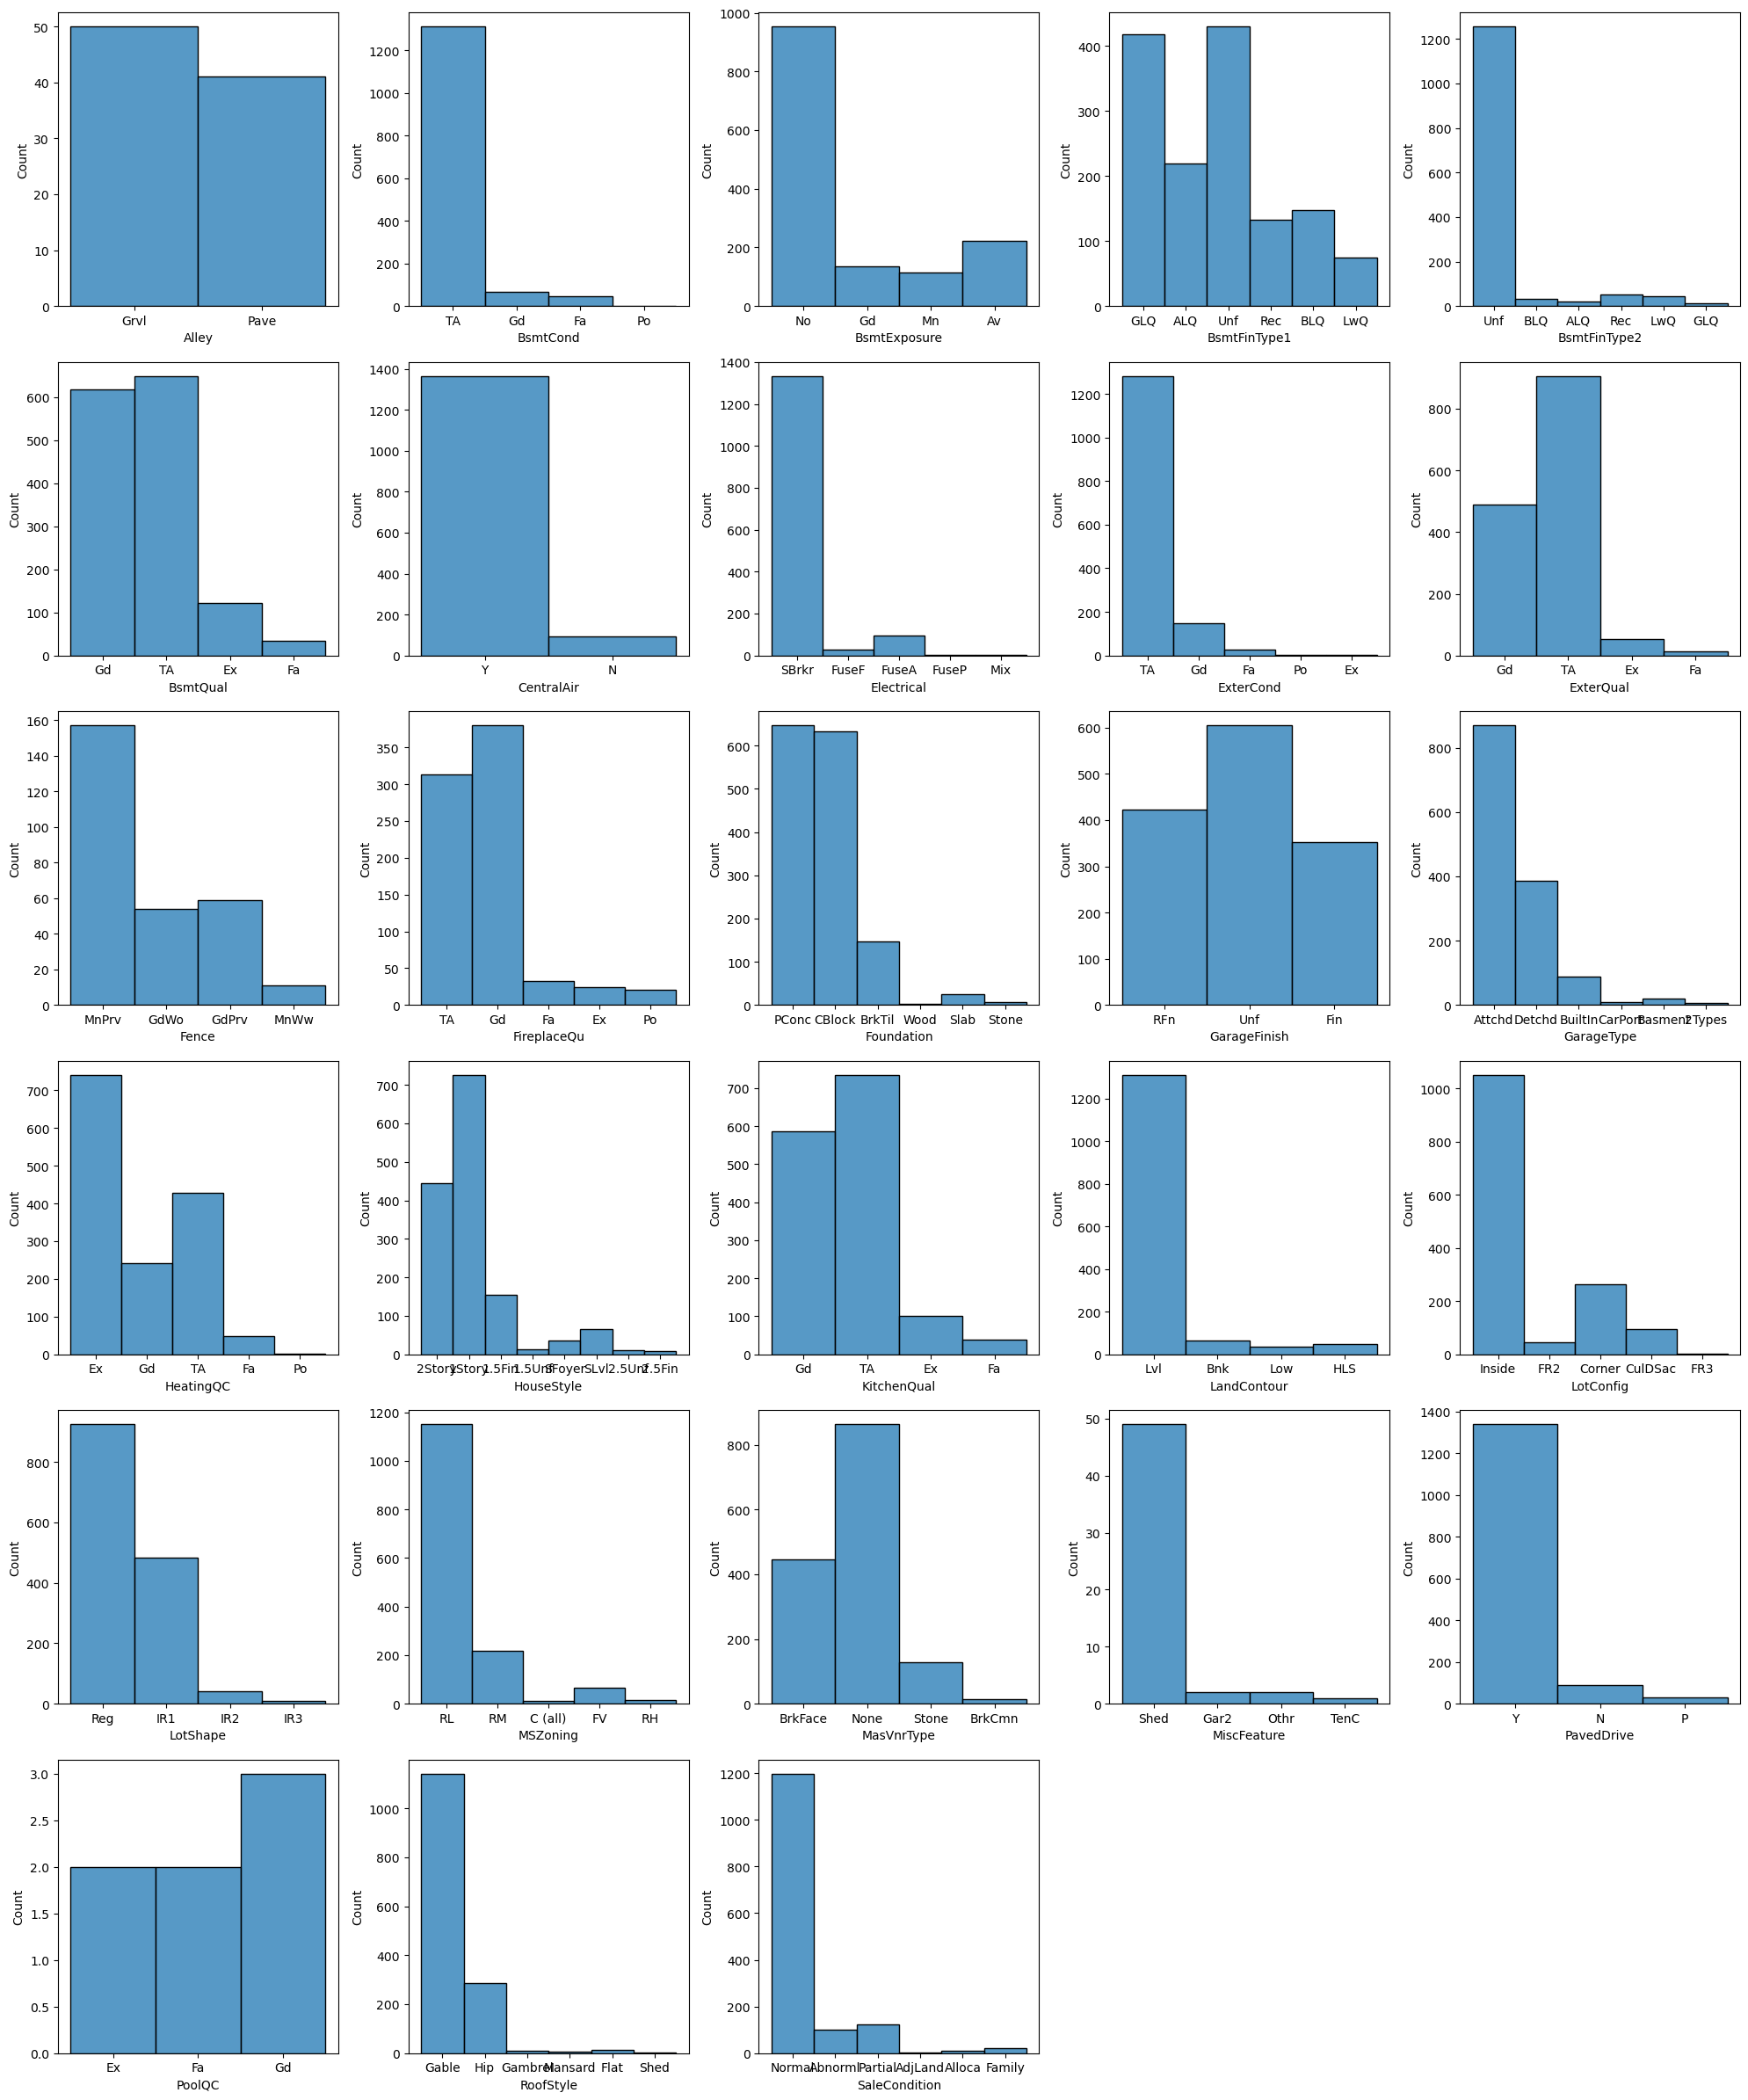

In [37]:
plot_list=feature_categorical

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

# Assuming 'X' is your DataFrame
num_cols = 5  # Number of columns in the grid
num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

# Plot each categorical feature
for i, feature in enumerate(plot_list):
    ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
    sns.histplot(data=X, x=feature, kde=False, ax=ax)

# Hide unused subplots
if len(plot_list) < num_rows * num_cols:
    for j in range(len(plot_list), num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()

## Distribution of each catigorical Ordinal feature

Categorical cat features (14): ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'GarageFinish', 'HeatingQC', 'KitchenQual', 'PoolQC']


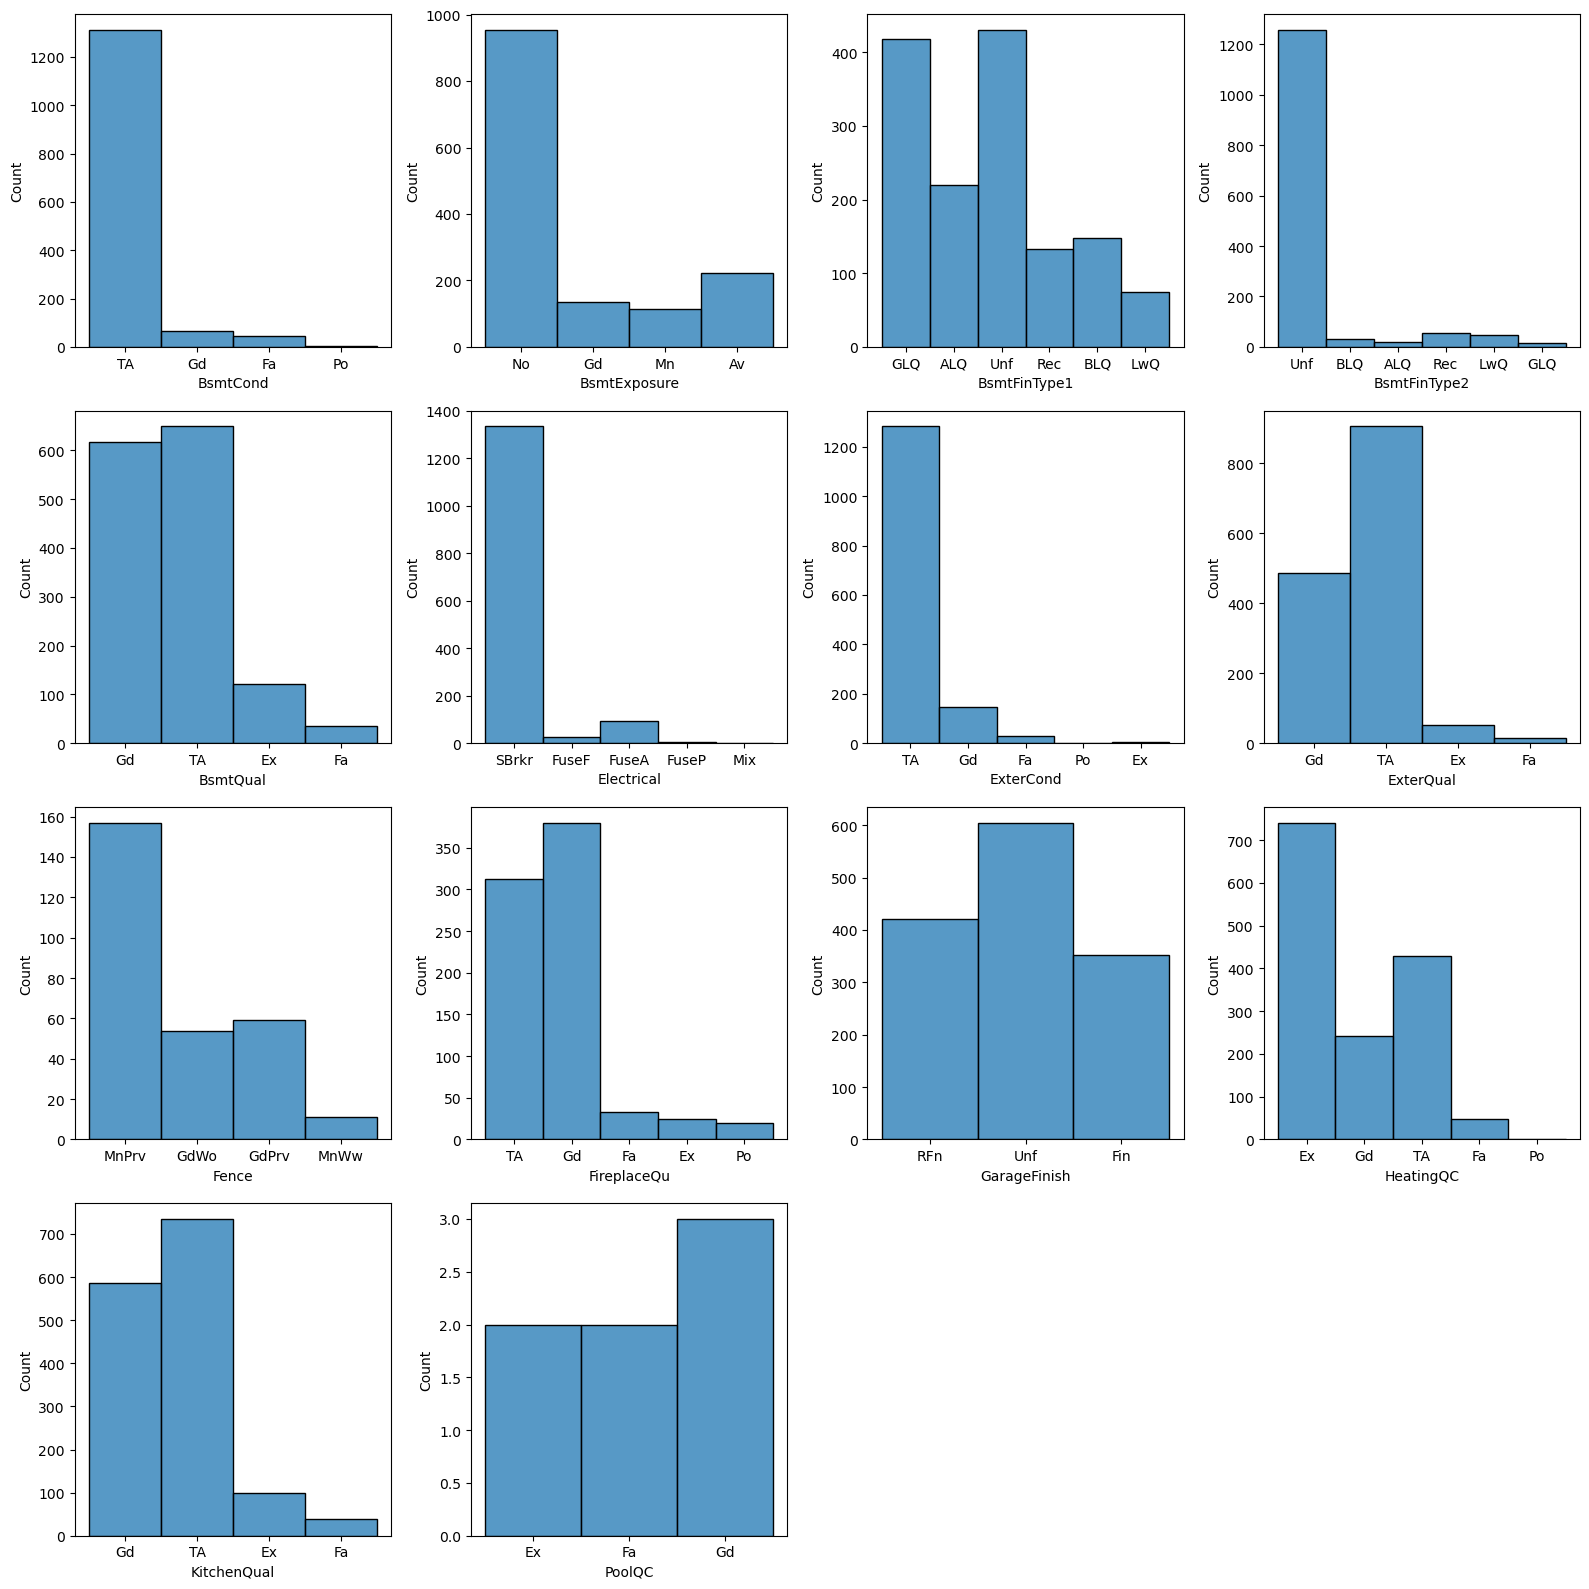

In [38]:
plot_list = feature_categorical_Ordinal

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

## Distribution of each catigorical OneHot feature

Categorical cat features (14): ['HouseStyle' 'Foundation' 'GarageType' 'RoofStyle' 'SaleCondition'
 'LotConfig' 'MSZoning' 'LandContour' 'LotShape' 'MasVnrType'
 'MiscFeature' 'PavedDrive' 'Alley' 'CentralAir']


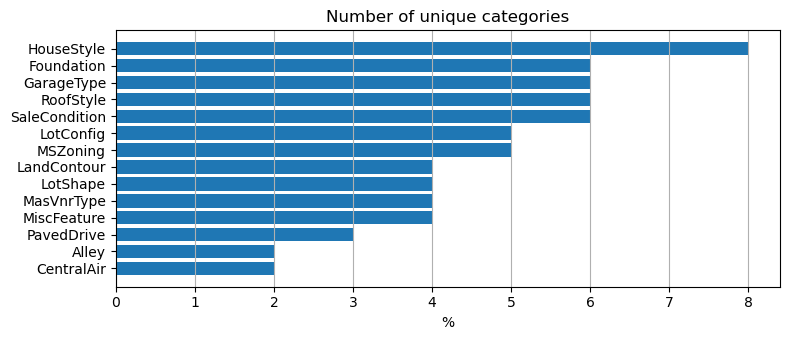

In [39]:
# list the number of categories of each OneHot feature
feature_cat_value_count= X[feature_categorical_OneHot].nunique().sort_values(ascending=False)
feature_cat_value_count=feature_cat_value_count[feature_cat_value_count>0]
plot_list = feature_cat_value_count[feature_cat_value_count>0].keys().values

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

# visualize
plt.figure(figsize=(8, len(plot_list)/4))
feature_ranks = range(len(plot_list))
bar = plt.barh(feature_cat_value_count.index, 
               feature_cat_value_count.values, 
               label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Number of unique categories")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

Categorical cat features (14): ['Alley', 'CentralAir', 'Foundation', 'GarageType', 'HouseStyle', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'PavedDrive', 'RoofStyle', 'SaleCondition']


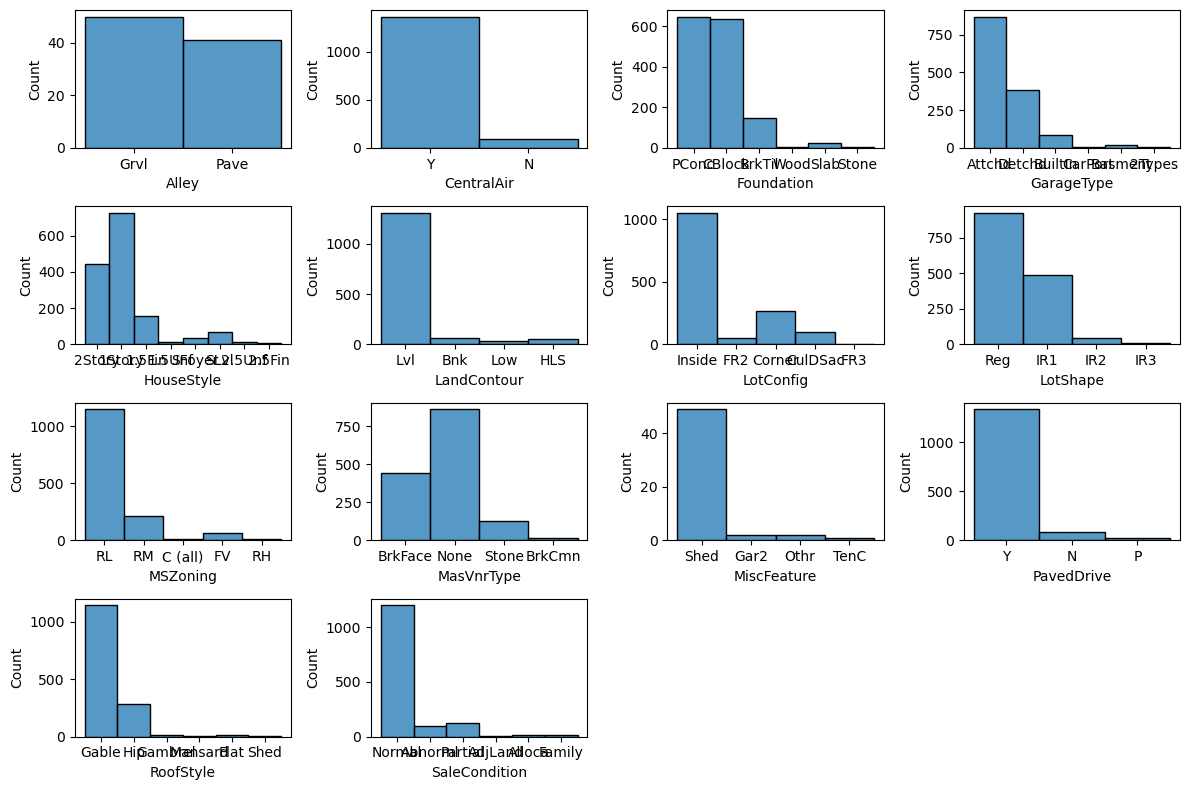

In [40]:
plot_list=feature_categorical_OneHot

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 2*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

# Data Preprocessing

In [25]:
#transformer for numerical data
preproc_num_norm = make_pipeline(
    SimpleImputer(strategy='mean'),
#     MinMaxScaler()
    RobustScaler(),
#     StandardScaler(),
#     PCA()
)

preproc_num_uniform = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler(),
#     RobustScaler(),
#     StandardScaler(),
#     PCA()
)

preproc_numerical = make_pipeline(
    SimpleImputer(strategy='mean'),
#     MinMaxScaler(),
#     RobustScaler(),
    StandardScaler(),
#     PCA(5)
)

preproc_cat_ordinal = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='Missing'),
    OrdinalEncoder(
        categories=feature_categorical_ordinal_values,
        dtype=np.int64,
        handle_unknown="use_encoded_value", unknown_value=-1
    ),
    MinMaxScaler()
)

preproc_cat_onehot = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(
        drop = 'if_binary',
        sparse_output=False,
        handle_unknown='ignore'),
)

preproc_pipeline = ColumnTransformer([
    ('ordinal processor', preproc_cat_ordinal, feature_categorical_Ordinal),
    ('numerical processor norm', preproc_num_norm, feature_numerical_norm),
    ('numerical processor uniform', preproc_num_uniform, feature_numerical_uniform),
    ('categorical processor', preproc_cat_onehot, feature_categorical_OneHot),
])

preproc_pipeline = ColumnTransformer([
    ('ordinal processor', preproc_cat_ordinal, feature_categorical_Ordinal),
    ('numerical processor', preproc_numerical, feature_numerical_norm + feature_numerical_uniform),
    ('categorical processor', preproc_cat_onehot, feature_categorical_OneHot),
])

display(preproc_pipeline)


X_preprocessed = preproc_pipeline.fit_transform(X)
X_preprocessed.shape, y.shape

ColumnTransformer(transformers=[('ordinal processor',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['missing',
                                                                              'Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd'],
                                                                             ['NA',
                                                                              'No',
                                                                              'Mn',
                                                                              'Av',
                                                                              'Gd'],
                                                                             ['NA',
                                                                              'Unf',
                                                                              'LwQ',
                                                                              'Rec',
                                                                              'BLQ',
                                                                              'ALQ',
                                                                              'GLQ'],
                                                                             ['NA',
                                                                              'Unf',
                                                                              'LwQ',
                                                                              'Rec',
                                                                              'BLQ',
                                                                              'ALQ',
                                                                              'GLQ'],
                                                                             ['NA',
                                                                              'Fa',
                                                                              'TA',
                                                                              'G...
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Exterior1st', 'Exterior2nd',
                                  'Foundation', 'GarageType', 'HouseStyle',
                                  'LandContour', 'LotConfig', 'LotShape',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'PavedDrive', 'RoofStyle',
                                  'SaleCondition', 'SaleType'])])

((1460, 188), (1460,))

# Models

## Custom Loss Function

In [19]:
def my_rmsle_neg(y_true, y_pred):
    return -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle_neg = make_scorer(my_rmsle_neg)

def my_rmsle(y_true, y_pred):
    return (np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle = make_scorer(my_rmsle)

print('complete')

complete


In [20]:
def my_rmsle(y_true, y_pred):
    return -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5 

from sklearn.metrics import make_scorer
rmsle = make_scorer(my_rmsle)

print('complete')

complete


## Cross Validation

In [30]:
# this code is to use cross validation to screen 
# all available models with default hyperparameters
# please comment out the models which are not relevant
from sklearn.preprocessing import PolynomialFeatures

models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'lightGBM Regressor': lgb.LGBMRegressor(),
    'SVM_Reg_rbf': SVR(kernel='rbf'),
    'XGBRegressor': xgb.XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVM_linear': SVR(kernel='linear'),
    'KNN Regressor': KNeighborsRegressor(),
    'SVM_poly': SVR(kernel='poly'),
    'Polynomial Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
}

# Add Polynomial Regression
X_poly = PolynomialFeatures(degree=2).fit_transform(X_preprocessed)

print('Baseline Score(s) of each model are ....')
for name in models:
    cv_result = cross_val_score(
        models[name], 
        X_poly if name == 'Polynomial Regression' else X_preprocessed,
        y_log, 
        cv=10, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1,
    )
    print(f'Average score: \033[94m{(-cv_result.mean())**.5}\033[0m by \033[94m{name}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.126689339090572 by GradientBoostingRegressor.
Average score: 0.1298944708088418 by lightGBM Regressor.
Average score: 0.13309284909891994 by SVM_Reg_rbf.
Average score: 0.1358405911719682 by XGBRegressor.
Average score: 0.1404862833892123 by RandomForestRegressor.
Average score: 0.14623504390461375 by SVM_linear.
Average score: 0.16287263438383667 by KNN Regressor.
Average score: 0.1926294358989925 by SVM_poly.
Average score: 0.19513389750455107 by Polynomial Regression.
Average score: 0.20185998588819282 by Decision Tree.


## Model Tuning

### SVM

In [22]:
%time
# Model tuning using uptuna

def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 0.00001, 10000.0),
        'epsilon': trial.suggest_uniform('epsilon', 0.01, 10.0),
#         'gamma': trial.suggest_loguniform('gamma', 0.0001, 10.0),
#         'coef0': trial.suggest_uniform('coef0', -1.0, 1.0),
#         'degree': trial.suggest_int('degree', 1, 5),
#         'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    }
    
    model = SVR(**params)
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  (-score)**.5

svm_reg_study = optuna.create_study(direction='minimize')
svm_reg_study.optimize(objective, n_jobs=-1, n_trials=100)
#store the best result
best_value = svm_reg_study.best_value
best_model = SVR(**svm_reg_study.best_params)
print(svm_reg_study.best_trial)

num_cpus = psutil.cpu_count(logical=True)
print(f'''\033[94m{num_cpus}\033[0m out of \033[94m{os.cpu_count()}\033[0m CPUs are used.''')

[I 2023-06-03 14:12:31,967] A new study created in memory with name: no-name-ce1fc038-f1dd-4fab-8d12-e685f6f08513
[I 2023-06-03 14:12:32,030] Trial 4 finished with value: 0.40027200451346 and parameters: {'C': 0.0033458616327805618, 'epsilon': 3.71417658490675}. Best is trial 4 with value: 0.40027200451346.
[I 2023-06-03 14:12:32,037] Trial 5 finished with value: 0.40027200451346007 and parameters: {'C': 0.04533454542376826, 'epsilon': 8.40939770051715}. Best is trial 4 with value: 0.40027200451346.
[I 2023-06-03 14:12:32,039] Trial 2 finished with value: 0.40027200451346 and parameters: {'C': 12.841539124143166, 'epsilon': 4.325510129996691}. Best is trial 4 with value: 0.40027200451346.
[I 2023-06-03 14:12:32,040] Trial 0 finished with value: 0.40027200451346 and parameters: {'C': 0.528822702502612, 'epsilon': 9.478778559804958}. Best is trial 4 with value: 0.40027200451346.
[I 2023-06-03 14:12:32,044] Trial 6 finished with value: 0.40027200451346 and parameters: {'C': 229.1704034909

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.3 µs


[I 2023-06-03 14:12:32,167] Trial 18 finished with value: 0.40027200451346 and parameters: {'C': 0.0013333842199554308, 'epsilon': 3.1386596365752957}. Best is trial 3 with value: 0.20094937274886604.
[I 2023-06-03 14:12:32,211] Trial 20 finished with value: 0.22518014627597321 and parameters: {'C': 31.455658135217, 'epsilon': 0.5026635037362815}. Best is trial 3 with value: 0.20094937274886604.
[I 2023-06-03 14:12:32,220] Trial 22 finished with value: 0.2445203248870576 and parameters: {'C': 7.159695208442327, 'epsilon': 0.6799922281113973}. Best is trial 3 with value: 0.20094937274886604.
[I 2023-06-03 14:12:32,247] Trial 23 finished with value: 0.22702244121411239 and parameters: {'C': 9441.766343176383, 'epsilon': 0.5116528153334741}. Best is trial 3 with value: 0.20094937274886604.
[I 2023-06-03 14:12:32,322] Trial 27 finished with value: 0.1712030065914339 and parameters: {'C': 9355.058732005402, 'epsilon': 0.2718050581343556}. Best is trial 27 with value: 0.1712030065914339.
[I 

[I 2023-06-03 14:12:33,822] Trial 51 finished with value: 0.14354281535450217 and parameters: {'C': 389.50997258107617, 'epsilon': 0.0563712407014664}. Best is trial 42 with value: 0.14021234828184886.
[I 2023-06-03 14:12:33,836] Trial 64 finished with value: 0.32691309377846944 and parameters: {'C': 1178.7742790645004, 'epsilon': 1.04938842107754}. Best is trial 42 with value: 0.14021234828184886.
[I 2023-06-03 14:12:33,861] Trial 65 finished with value: 0.3529268069513494 and parameters: {'C': 1199.3124018216497, 'epsilon': 1.1611649789198797}. Best is trial 42 with value: 0.14021234828184886.
[I 2023-06-03 14:12:33,880] Trial 66 finished with value: 0.37803368711423346 and parameters: {'C': 1500.2095278262561, 'epsilon': 1.3033777004140583}. Best is trial 42 with value: 0.14021234828184886.
[I 2023-06-03 14:12:33,923] Trial 68 finished with value: 0.22216436986835494 and parameters: {'C': 3061.7463807969343, 'epsilon': 0.486209730803175}. Best is trial 42 with value: 0.1402123482818

[I 2023-06-03 14:12:34,809] Trial 96 finished with value: 0.1715595132436053 and parameters: {'C': 698.2554954811416, 'epsilon': 0.27381318004646765}. Best is trial 42 with value: 0.14021234828184886.
[I 2023-06-03 14:12:34,853] Trial 71 finished with value: 0.14313690630003878 and parameters: {'C': 142.68276871176528, 'epsilon': 0.048033155057224386}. Best is trial 42 with value: 0.14021234828184886.
[I 2023-06-03 14:12:35,404] Trial 98 finished with value: 0.14357750312183298 and parameters: {'C': 57.87920946917874, 'epsilon': 0.056985540648495564}. Best is trial 42 with value: 0.14021234828184886.
[I 2023-06-03 14:12:35,433] Trial 97 finished with value: 0.14341905279074071 and parameters: {'C': 9286.335729796325, 'epsilon': 0.05419764929705916}. Best is trial 42 with value: 0.14021234828184886.
[I 2023-06-03 14:12:35,710] Trial 99 finished with value: 0.14285393907023747 and parameters: {'C': 1389.5993545648691, 'epsilon': 0.02719914411277407}. Best is trial 42 with value: 0.140212

FrozenTrial(number=42, state=TrialState.COMPLETE, values=[0.14021234828184886], datetime_start=datetime.datetime(2023, 6, 3, 14, 12, 32, 646696), datetime_complete=datetime.datetime(2023, 6, 3, 14, 12, 33, 340527), params={'C': 1.2073378868096012, 'epsilon': 0.06442714943944612}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10000.0, log=True, low=1e-05, step=None), 'epsilon': FloatDistribution(high=10.0, log=False, low=0.01, step=None)}, trial_id=42, value=None)
10 out of 10 CPUs are used.


In [ ]:
best_model

### Gradient Boost

In [47]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    model = GradientBoostingRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

gd_study = optuna.create_study(direction='maximize')
gd_study.optimize(objective, n_jobs=-1, n_trials=1000)

best_gd_model = GradientBoostingRegressor(**gd_study.best_params)
best_value = gd_study.best_value
print(gd_study.best_trial)

num_cpus = psutil.cpu_count(logical=True)
print(f'''\033[94m{num_cpus}\033[0m out of \033[94m{os.cpu_count()}\033[0m CPUs are used.''')

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-06-03 14:53:54,674] Trial 997 finished with value: -0.1283617728415751 and 
# parameters: {'n_estimators': 481, 'learning_rate': 0.060723490119515625, 'max_depth': 4, 
# 'min_samples_split': 19, 'min_samples_leaf': 2, 'subsample': 0.989948030051472}. 
# Best is trial 718 with value: -0.12398226502217731.

# FrozenTrial(number=718, state=TrialState.COMPLETE, values=[-0.12398226502217731], 
# datetime_start=datetime.datetime(2023, 6, 3, 14, 46, 41, 528304), 
# datetime_complete=datetime.datetime(2023, 6, 3, 14, 46, 54, 402552), 
# params={'n_estimators': 480, 'learning_rate': 0.07309915309517608, 'max_depth': 3, 'min_samples_split': 20,
# 'min_samples_leaf': 1, 'subsample': 0.6720825030145895}, user_attrs={}, system_attrs={}, 
# intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1),
# 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.001, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 
# 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=718, value=None)

[I 2023-06-03 14:29:22,385] A new study created in memory with name: no-name-d3bec843-5eb0-42fe-ba6b-74f72891e720
[I 2023-06-03 14:29:27,798] Trial 2 finished with value: -0.13487108231400255 and parameters: {'n_estimators': 161, 'learning_rate': 0.1573773606932426, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 7, 'subsample': 0.9411442205682684}. Best is trial 2 with value: -0.13487108231400255.
[I 2023-06-03 14:29:27,922] Trial 0 finished with value: -0.1364815436538959 and parameters: {'n_estimators': 111, 'learning_rate': 0.16261775992728852, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 2, 'subsample': 0.8804077124400362}. Best is trial 2 with value: -0.13487108231400255.
[I 2023-06-03 14:29:28,863] Trial 11 finished with value: -0.1360642599230408 and parameters: {'n_estimators': 53, 'learning_rate': 0.15300046306065387, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 8, 'subsample': 0.5086601072733239}. Best is trial 2 with value: -0.134

[I 2023-06-03 14:29:57,766] Trial 24 finished with value: -0.13504137856203946 and parameters: {'n_estimators': 306, 'learning_rate': 0.08239428008788283, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 10, 'subsample': 0.7696033533071508}. Best is trial 9 with value: -0.1292243338573986.
[I 2023-06-03 14:29:59,097] Trial 27 finished with value: -0.13297080859688576 and parameters: {'n_estimators': 288, 'learning_rate': 0.08872300710403186, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 4, 'subsample': 0.7580861808610271}. Best is trial 9 with value: -0.1292243338573986.
[I 2023-06-03 14:30:02,525] Trial 28 finished with value: -0.13231003985096584 and parameters: {'n_estimators': 273, 'learning_rate': 0.08097466397400954, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 4, 'subsample': 0.7417346321020524}. Best is trial 9 with value: -0.1292243338573986.
[I 2023-06-03 14:30:04,840] Trial 30 finished with value: -0.13500817811470037 and parameters

[I 2023-06-03 14:30:35,829] Trial 52 finished with value: -0.12658706416397184 and parameters: {'n_estimators': 401, 'learning_rate': 0.02723672525526666, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 3, 'subsample': 0.8217059192054277}. Best is trial 52 with value: -0.12658706416397184.
[I 2023-06-03 14:30:36,340] Trial 55 finished with value: -0.12752485218589218 and parameters: {'n_estimators': 356, 'learning_rate': 0.022631951874297288, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 3, 'subsample': 0.7268375635630068}. Best is trial 52 with value: -0.12658706416397184.
[I 2023-06-03 14:30:37,129] Trial 53 finished with value: -0.1274844395945303 and parameters: {'n_estimators': 416, 'learning_rate': 0.025892272411433184, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 3, 'subsample': 0.6580480640541531}. Best is trial 52 with value: -0.12658706416397184.
[I 2023-06-03 14:30:37,427] Trial 56 finished with value: -0.12786074534044736 and para

[I 2023-06-03 14:31:16,082] Trial 78 finished with value: -0.12841710931581668 and parameters: {'n_estimators': 477, 'learning_rate': 0.031895812396503395, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 2, 'subsample': 0.6234910734568813}. Best is trial 71 with value: -0.12561926164314116.
[I 2023-06-03 14:31:19,121] Trial 79 finished with value: -0.1275809751108513 and parameters: {'n_estimators': 480, 'learning_rate': 0.014070325873718708, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 2, 'subsample': 0.6392333876083195}. Best is trial 71 with value: -0.12561926164314116.
[I 2023-06-03 14:31:20,303] Trial 84 finished with value: -0.1313874297624593 and parameters: {'n_estimators': 477, 'learning_rate': 0.015335768313061857, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 5, 'subsample': 0.6366762411829308}. Best is trial 71 with value: -0.12561926164314116.
[I 2023-06-03 14:31:21,142] Trial 85 finished with value: -0.13355757550181954 and para

[I 2023-06-03 14:31:57,257] Trial 106 finished with value: -0.1267583220395186 and parameters: {'n_estimators': 467, 'learning_rate': 0.017423644004229782, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0.6806863886497101}. Best is trial 71 with value: -0.12561926164314116.
[I 2023-06-03 14:31:57,322] Trial 103 finished with value: -0.12634939706492646 and parameters: {'n_estimators': 469, 'learning_rate': 0.017670753851614082, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 1, 'subsample': 0.5712274123899957}. Best is trial 71 with value: -0.12561926164314116.
[I 2023-06-03 14:31:59,974] Trial 107 finished with value: -0.12709974122050224 and parameters: {'n_estimators': 484, 'learning_rate': 0.01769115416599374, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 3, 'subsample': 0.6770759824522076}. Best is trial 71 with value: -0.12561926164314116.
[I 2023-06-03 14:32:00,609] Trial 105 finished with value: -0.12733023428647244 and 

[I 2023-06-03 14:32:40,029] Trial 130 finished with value: -0.13214386463437378 and parameters: {'n_estimators': 449, 'learning_rate': 0.007094733107946274, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 2, 'subsample': 0.6313199524332926}. Best is trial 112 with value: -0.12558801082386736.
[I 2023-06-03 14:32:40,538] Trial 131 finished with value: -0.1285410343570895 and parameters: {'n_estimators': 456, 'learning_rate': 0.008424385304351542, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 2, 'subsample': 0.6125315484451226}. Best is trial 112 with value: -0.12558801082386736.
[I 2023-06-03 14:32:42,205] Trial 132 finished with value: -0.12825641966226756 and parameters: {'n_estimators': 458, 'learning_rate': 0.0083185038826665, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 2, 'subsample': 0.6306164086660361}. Best is trial 112 with value: -0.12558801082386736.
[I 2023-06-03 14:32:44,271] Trial 133 finished with value: -0.1287438925623781 and

[I 2023-06-03 14:33:14,826] Trial 154 finished with value: -0.12487026530858214 and parameters: {'n_estimators': 479, 'learning_rate': 0.02553237786573679, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6992779024203205}. Best is trial 154 with value: -0.12487026530858214.
[I 2023-06-03 14:33:17,617] Trial 155 finished with value: -0.12506186372420192 and parameters: {'n_estimators': 475, 'learning_rate': 0.026326512578591924, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6198656738932835}. Best is trial 154 with value: -0.12487026530858214.
[I 2023-06-03 14:33:19,436] Trial 156 finished with value: -0.12606137910881288 and parameters: {'n_estimators': 479, 'learning_rate': 0.027510532913046004, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6969023834076445}. Best is trial 154 with value: -0.12487026530858214.
[I 2023-06-03 14:33:21,160] Trial 166 finished with value: -0.1277493281079055 a

[I 2023-06-03 14:33:53,885] Trial 182 finished with value: -0.12573872272418313 and parameters: {'n_estimators': 491, 'learning_rate': 0.03375034597385353, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6866711613764763}. Best is trial 154 with value: -0.12487026530858214.
[I 2023-06-03 14:33:54,271] Trial 183 finished with value: -0.12643268432139468 and parameters: {'n_estimators': 486, 'learning_rate': 0.03304676711712303, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6806951537059528}. Best is trial 154 with value: -0.12487026530858214.
[I 2023-06-03 14:33:54,792] Trial 184 finished with value: -0.1274903566580849 and parameters: {'n_estimators': 486, 'learning_rate': 0.04852634638722281, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6867026411782059}. Best is trial 154 with value: -0.12487026530858214.
[I 2023-06-03 14:33:57,801] Trial 186 finished with value: -0.1261394214113138 and 

[I 2023-06-03 14:34:29,523] Trial 208 finished with value: -0.12494631904974825 and parameters: {'n_estimators': 464, 'learning_rate': 0.024393985502589692, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6704005935264039}. Best is trial 201 with value: -0.12456473372293046.
[I 2023-06-03 14:34:32,649] Trial 209 finished with value: -0.12444928680026542 and parameters: {'n_estimators': 463, 'learning_rate': 0.01970088012721642, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6547904973112247}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:34:35,579] Trial 211 finished with value: -0.1263503901683937 and parameters: {'n_estimators': 459, 'learning_rate': 0.019126383328915003, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.6567818301756347}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:34:35,880] Trial 212 finished with value: -0.12638273026233976 an

[I 2023-06-03 14:35:07,487] Trial 233 finished with value: -0.1252696338709223 and parameters: {'n_estimators': 500, 'learning_rate': 0.028837128228159793, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.681824087847068}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:35:08,215] Trial 235 finished with value: -0.12547832056368957 and parameters: {'n_estimators': 484, 'learning_rate': 0.029120422639719857, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6801186617212875}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:35:09,056] Trial 236 finished with value: -0.12479343780407037 and parameters: {'n_estimators': 483, 'learning_rate': 0.02270972664621185, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6643742934780229}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:35:10,411] Trial 237 finished with value: -0.12679446226238997 an

[I 2023-06-03 14:35:49,128] Trial 260 finished with value: -0.12850446274780522 and parameters: {'n_estimators': 472, 'learning_rate': 0.06691517545274925, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.639206324687185}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:35:49,796] Trial 261 finished with value: -0.1263404387408693 and parameters: {'n_estimators': 472, 'learning_rate': 0.015008877044409591, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.636767837665342}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:35:50,948] Trial 262 finished with value: -0.12671922498410676 and parameters: {'n_estimators': 472, 'learning_rate': 0.015411682437622375, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6431356686030586}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:35:51,363] Trial 263 finished with value: -0.1258587162581648 and 

[I 2023-06-03 14:36:23,619] Trial 286 finished with value: -0.12512107026987548 and parameters: {'n_estimators': 488, 'learning_rate': 0.024973172816900792, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6849561720875946}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:36:24,608] Trial 287 finished with value: -0.13023678342647438 and parameters: {'n_estimators': 491, 'learning_rate': 0.0395239643086855, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 7, 'subsample': 0.6587945882486749}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:36:28,293] Trial 289 finished with value: -0.12590008169169123 and parameters: {'n_estimators': 490, 'learning_rate': 0.03604836202325643, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6249560735221914}. Best is trial 209 with value: -0.12444928680026542.
[I 2023-06-03 14:36:28,514] Trial 288 finished with value: -0.12908706865380146 an

[I 2023-06-03 14:36:58,636] Trial 310 finished with value: -0.1262164947479988 and parameters: {'n_estimators': 464, 'learning_rate': 0.025697435606692097, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.7845174790351288}. Best is trial 306 with value: -0.12443621256893597.
[I 2023-06-03 14:37:01,701] Trial 313 finished with value: -0.12440263298450432 and parameters: {'n_estimators': 467, 'learning_rate': 0.026740666313959115, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.7730080693750075}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:37:04,323] Trial 316 finished with value: -0.12543165656340488 and parameters: {'n_estimators': 465, 'learning_rate': 0.026743487842157927, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6049954552227959}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:37:05,489] Trial 314 finished with value: -0.12569432304142097 

[I 2023-06-03 14:37:37,305] Trial 337 finished with value: -0.1261520867842608 and parameters: {'n_estimators': 498, 'learning_rate': 0.0425722456891355, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.7403978616726011}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:37:39,799] Trial 341 finished with value: -0.12815016999048126 and parameters: {'n_estimators': 479, 'learning_rate': 0.09775660677561283, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.5082148738504249}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:37:40,893] Trial 339 finished with value: -0.12639633695689792 and parameters: {'n_estimators': 500, 'learning_rate': 0.0320804532388953, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.7790689963194882}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:37:42,783] Trial 340 finished with value: -0.12638553941205066 and p

[I 2023-06-03 14:38:17,948] Trial 364 finished with value: -0.12668719948177423 and parameters: {'n_estimators': 488, 'learning_rate': 0.022101966630113698, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 2, 'subsample': 0.6691482396562205}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:38:19,633] Trial 365 finished with value: -0.1296112100579092 and parameters: {'n_estimators': 491, 'learning_rate': 0.022671226051519968, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 6, 'subsample': 0.6686503683491924}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:38:20,357] Trial 366 finished with value: -0.13019404839343648 and parameters: {'n_estimators': 489, 'learning_rate': 0.07684243384551061, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6669581578946413}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:38:20,498] Trial 367 finished with value: -0.13363965813861034 a

[I 2023-06-03 14:38:53,796] Trial 389 finished with value: -0.1280780177901733 and parameters: {'n_estimators': 458, 'learning_rate': 0.04871355005682286, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6877487534127428}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:38:54,089] Trial 390 finished with value: -0.12588822166197214 and parameters: {'n_estimators': 442, 'learning_rate': 0.02848677527761192, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.7077773132935048}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:38:56,878] Trial 392 finished with value: -0.12527420352535268 and parameters: {'n_estimators': 440, 'learning_rate': 0.028684648596169492, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6893001963687653}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:38:57,161] Trial 400 finished with value: -0.1333032093086808 and

[I 2023-06-03 14:39:32,416] Trial 417 finished with value: -0.1248128016625916 and parameters: {'n_estimators': 467, 'learning_rate': 0.025593094480273894, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.7203438224192736}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:39:33,581] Trial 415 finished with value: -0.12873656708835404 and parameters: {'n_estimators': 475, 'learning_rate': 0.07174399227950523, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.9978231188871609}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:39:33,861] Trial 419 finished with value: -0.12682318281350438 and parameters: {'n_estimators': 467, 'learning_rate': 0.0504618010899547, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.5905414067058603}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:39:34,173] Trial 418 finished with value: -0.1280344704876526 and 

[I 2023-06-03 14:40:10,615] Trial 443 finished with value: -0.1268505665722589 and parameters: {'n_estimators': 486, 'learning_rate': 0.01075665672605707, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.678819360709917}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:40:12,371] Trial 444 finished with value: -0.12657611022878545 and parameters: {'n_estimators': 483, 'learning_rate': 0.031083278256458624, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.7495343318240798}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:40:12,715] Trial 442 finished with value: -0.1310997536151985 and parameters: {'n_estimators': 485, 'learning_rate': 0.1540066100412597, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.9704628175821616}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:40:14,373] Trial 445 finished with value: -0.13031831432606947 and p

[I 2023-06-03 14:40:46,508] Trial 467 finished with value: -0.12625456264757032 and parameters: {'n_estimators': 471, 'learning_rate': 0.04046655267143505, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6378147312301736}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:40:46,618] Trial 470 finished with value: -0.12589489404336338 and parameters: {'n_estimators': 311, 'learning_rate': 0.03497503508502486, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.6787982846671463}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:40:50,592] Trial 469 finished with value: -0.12685168110464187 and parameters: {'n_estimators': 494, 'learning_rate': 0.036339013143441595, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6783620938259673}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:40:53,033] Trial 473 finished with value: -0.12644161002985702 an

[I 2023-06-03 14:41:24,243] Trial 495 finished with value: -0.1253339400922367 and parameters: {'n_estimators': 442, 'learning_rate': 0.02015854414238013, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6132089850445038}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:41:25,106] Trial 493 finished with value: -0.13289464995995423 and parameters: {'n_estimators': 471, 'learning_rate': 0.16029871818876923, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.787513145755643}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:41:27,746] Trial 496 finished with value: -0.12526025453625142 and parameters: {'n_estimators': 434, 'learning_rate': 0.01662175940699471, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6026687768936041}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:41:29,403] Trial 497 finished with value: -0.1266250021645435 and p

[I 2023-06-03 14:42:03,944] Trial 509 finished with value: -0.13711359737170858 and parameters: {'n_estimators': 477, 'learning_rate': 0.08184396364277463, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 1, 'subsample': 0.8658033897735821}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:42:04,101] Trial 521 finished with value: -0.13733670915832552 and parameters: {'n_estimators': 452, 'learning_rate': 0.15001684499966947, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 5, 'subsample': 0.5210461813337799}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:42:08,290] Trial 522 finished with value: -0.13250467946869404 and parameters: {'n_estimators': 452, 'learning_rate': 0.1536215639360678, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.7593294764997216}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:42:08,704] Trial 523 finished with value: -0.1269554184415555 and

[I 2023-06-03 14:42:41,752] Trial 544 finished with value: -0.1465279039147141 and parameters: {'n_estimators': 485, 'learning_rate': 0.006070613335807405, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.7354612794463149}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:42:43,684] Trial 548 finished with value: -0.12634483172943722 and parameters: {'n_estimators': 486, 'learning_rate': 0.022083349879204916, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6087377782421095}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:42:44,692] Trial 546 finished with value: -0.13133218565259724 and parameters: {'n_estimators': 485, 'learning_rate': 0.12264673362507594, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6913292436175623}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:42:45,338] Trial 549 finished with value: -0.13369486794836552 an

[I 2023-06-03 14:43:18,268] Trial 569 finished with value: -0.1255644949182551 and parameters: {'n_estimators': 471, 'learning_rate': 0.016632813428215924, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.5910850931268776}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:43:19,296] Trial 573 finished with value: -0.27414998684152747 and parameters: {'n_estimators': 484, 'learning_rate': 0.0011703121450811274, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.5757685200229856}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:43:23,365] Trial 574 finished with value: -0.1280066823404738 and parameters: {'n_estimators': 446, 'learning_rate': 0.030647904375402435, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 3, 'subsample': 0.5296991699833237}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:43:26,037] Trial 575 finished with value: -0.13293775649710352 

[I 2023-06-03 14:43:58,641] Trial 596 finished with value: -0.136795998432062 and parameters: {'n_estimators': 464, 'learning_rate': 0.19088232639592967, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.8004853967235666}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:43:59,126] Trial 604 finished with value: -0.12942680919481975 and parameters: {'n_estimators': 248, 'learning_rate': 0.018419703285473245, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6277622674377522}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:43:59,156] Trial 602 finished with value: -0.12793254419364594 and parameters: {'n_estimators': 245, 'learning_rate': 0.019884885153010137, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.7405029931127138}. Best is trial 313 with value: -0.12440263298450432.
[I 2023-06-03 14:43:59,893] Trial 597 finished with value: -0.13521403184725178 an

[I 2023-06-03 14:44:37,550] Trial 626 finished with value: -0.1271595111946929 and parameters: {'n_estimators': 500, 'learning_rate': 0.016759105745151617, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.5470733536302215}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:44:39,937] Trial 621 finished with value: -0.1261463239960286 and parameters: {'n_estimators': 497, 'learning_rate': 0.015562866989964973, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1, 'subsample': 0.6486906315020091}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:44:40,030] Trial 627 finished with value: -0.1264189432651378 and parameters: {'n_estimators': 487, 'learning_rate': 0.07026565923440328, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.7067250852666097}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:44:40,646] Trial 622 finished with value: -0.13712252910804523 and 

[I 2023-06-03 14:45:14,740] Trial 647 finished with value: -0.12762730910384673 and parameters: {'n_estimators': 477, 'learning_rate': 0.05232932596168613, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.9284097126984834}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:45:17,233] Trial 650 finished with value: -0.12639598945920327 and parameters: {'n_estimators': 480, 'learning_rate': 0.02619725579800567, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6833510938241586}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:45:18,468] Trial 651 finished with value: -0.12620698180920967 and parameters: {'n_estimators': 481, 'learning_rate': 0.027375112808148236, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6836407887515321}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:45:19,094] Trial 652 finished with value: -0.12540789002446773 a

[I 2023-06-03 14:45:51,566] Trial 676 finished with value: -0.1307398219515728 and parameters: {'n_estimators': 461, 'learning_rate': 0.09731495576837015, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.5981134360223648}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:45:51,802] Trial 674 finished with value: -0.12635679444080558 and parameters: {'n_estimators': 454, 'learning_rate': 0.023886548147450136, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.9088708762820761}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:45:54,835] Trial 677 finished with value: -0.12843989269064549 and parameters: {'n_estimators': 462, 'learning_rate': 0.06739600675516555, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.6161760360885008}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:46:00,843] Trial 680 finished with value: -0.13656715434405553 an

[I 2023-06-03 14:46:31,157] Trial 701 finished with value: -0.12670254412087997 and parameters: {'n_estimators': 493, 'learning_rate': 0.017188779749680697, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.7182011039354115}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:46:31,598] Trial 703 finished with value: -0.131448764219232 and parameters: {'n_estimators': 361, 'learning_rate': 0.11499123529849985, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'subsample': 0.6546609465138061}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:46:35,438] Trial 706 finished with value: -0.12953050881313966 and parameters: {'n_estimators': 355, 'learning_rate': 0.013159560333397793, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6555318596822418}. Best is trial 608 with value: -0.12421730468254266.
[I 2023-06-03 14:46:38,004] Trial 707 finished with value: -0.13052357902229728 and

[I 2023-06-03 14:47:13,536] Trial 729 finished with value: -0.12757214106689657 and parameters: {'n_estimators': 479, 'learning_rate': 0.0705526320925204, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.672156619879521}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:47:14,343] Trial 730 finished with value: -0.1310875975384082 and parameters: {'n_estimators': 481, 'learning_rate': 0.07744082937874665, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 8, 'subsample': 0.6380003656965391}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:47:14,407] Trial 727 finished with value: -0.13211735167911343 and parameters: {'n_estimators': 478, 'learning_rate': 0.12552674155748314, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.8728123940853842}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:47:16,794] Trial 732 finished with value: -0.12551461522062055 and p

[I 2023-06-03 14:47:51,041] Trial 752 finished with value: -0.12802519831682294 and parameters: {'n_estimators': 500, 'learning_rate': 0.07930073278621784, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.8851503195903122}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:47:51,768] Trial 755 finished with value: -0.12596904027687217 and parameters: {'n_estimators': 470, 'learning_rate': 0.02175444067102656, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6598992488930606}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:47:52,512] Trial 756 finished with value: -0.12581230419514985 and parameters: {'n_estimators': 470, 'learning_rate': 0.026350332866246863, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6598975945150996}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:47:53,925] Trial 758 finished with value: -0.12818159017577546 a

[I 2023-06-03 14:48:27,631] Trial 780 finished with value: -0.12756911176552793 and parameters: {'n_estimators': 448, 'learning_rate': 0.03709825586516757, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 2, 'subsample': 0.6795450539154722}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:48:32,019] Trial 782 finished with value: -0.12712993218260288 and parameters: {'n_estimators': 476, 'learning_rate': 0.02798327052377717, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 2, 'subsample': 0.7081272181072769}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:48:33,065] Trial 783 finished with value: -0.12764991950305649 and parameters: {'n_estimators': 476, 'learning_rate': 0.04907504130667448, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 2, 'subsample': 0.7071994667832926}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:48:33,089] Trial 781 finished with value: -0.12758847835698656 an

[I 2023-06-03 14:49:06,287] Trial 804 finished with value: -0.1348959845481068 and parameters: {'n_estimators': 490, 'learning_rate': 0.10135188115498289, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6513767854045857}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:49:08,467] Trial 811 finished with value: -0.12675473858580724 and parameters: {'n_estimators': 337, 'learning_rate': 0.020413641719148865, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.9021460929849052}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:49:08,679] Trial 807 finished with value: -0.1339519313508684 and parameters: {'n_estimators': 473, 'learning_rate': 0.19253491557541036, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.7677943458322383}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:49:09,220] Trial 809 finished with value: -0.12474553558726925 and

[I 2023-06-03 14:49:48,236] Trial 832 finished with value: -0.16104418743980783 and parameters: {'n_estimators': 453, 'learning_rate': 0.004270136821908806, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.8761591472216264}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:49:48,842] Trial 833 finished with value: -0.13218283911198614 and parameters: {'n_estimators': 480, 'learning_rate': 0.16281379820382103, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.7690407943251123}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:49:52,020] Trial 834 finished with value: -0.1329253343745653 and parameters: {'n_estimators': 479, 'learning_rate': 0.007673626394595829, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.8472691916703794}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:49:52,173] Trial 836 finished with value: -0.12567126096601985 and 

[I 2023-06-03 14:50:22,958] Trial 858 finished with value: -0.2767703444628595 and parameters: {'n_estimators': 466, 'learning_rate': 0.0011839787513484232, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6729610323001167}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:50:25,960] Trial 860 finished with value: -0.12857722508577843 and parameters: {'n_estimators': 467, 'learning_rate': 0.054717090469252376, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6723973132993478}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:50:29,087] Trial 861 finished with value: -0.13024586119966372 and parameters: {'n_estimators': 500, 'learning_rate': 0.12893375841110075, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6727676047975563}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:50:29,520] Trial 862 finished with value: -0.12556720645876338 

[I 2023-06-03 14:51:04,157] Trial 883 finished with value: -0.12564792112222006 and parameters: {'n_estimators': 481, 'learning_rate': 0.03515559619935414, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.6266904649581773}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:51:05,202] Trial 884 finished with value: -0.12687995296670526 and parameters: {'n_estimators': 445, 'learning_rate': 0.03481528876921164, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.8270163760654644}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:51:05,751] Trial 885 finished with value: -0.1258410768665356 and parameters: {'n_estimators': 445, 'learning_rate': 0.02245385125076653, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 2, 'subsample': 0.6923837274493343}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:51:06,769] Trial 886 finished with value: -0.13754741960445382 and

[I 2023-06-03 14:51:43,115] Trial 910 finished with value: -0.1273533019544054 and parameters: {'n_estimators': 462, 'learning_rate': 0.03127009833912173, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6448000026552199}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:51:45,077] Trial 911 finished with value: -0.1256277363112749 and parameters: {'n_estimators': 463, 'learning_rate': 0.03105660100223953, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.7029485796449795}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:51:46,832] Trial 913 finished with value: -0.12944645325844828 and parameters: {'n_estimators': 393, 'learning_rate': 0.060096243128526766, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6427594376517194}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:51:47,697] Trial 912 finished with value: -0.13039119015860307 and

[I 2023-06-03 14:52:19,737] Trial 936 finished with value: -0.12568362093634883 and parameters: {'n_estimators': 473, 'learning_rate': 0.02308407081233086, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6289768314057014}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:52:20,428] Trial 934 finished with value: -0.1256191222062694 and parameters: {'n_estimators': 470, 'learning_rate': 0.02243385897271847, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6210188441688984}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:52:20,821] Trial 938 finished with value: -0.12670544800326286 and parameters: {'n_estimators': 471, 'learning_rate': 0.023359215354587543, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6197203120555838}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:52:24,420] Trial 940 finished with value: -0.124083590783622 and 

[I 2023-06-03 14:53:04,086] Trial 963 finished with value: -0.13438500736859657 and parameters: {'n_estimators': 494, 'learning_rate': 0.15715198773891842, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.60125175661178}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:53:04,313] Trial 962 finished with value: -0.13381181810702333 and parameters: {'n_estimators': 491, 'learning_rate': 0.1496659171917109, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6519145970661574}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:53:04,852] Trial 964 finished with value: -0.12794517636579175 and parameters: {'n_estimators': 492, 'learning_rate': 0.045730426747232204, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6126149264504304}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:53:08,823] Trial 965 finished with value: -0.1260075378814913 and p

[I 2023-06-03 14:53:40,303] Trial 986 finished with value: -0.13124622326536997 and parameters: {'n_estimators': 463, 'learning_rate': 0.1314398243762826, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.8764177098606654}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:53:44,039] Trial 990 finished with value: -0.12652827913652584 and parameters: {'n_estimators': 458, 'learning_rate': 0.03349374928939277, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.6476755232132284}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:53:44,755] Trial 989 finished with value: -0.13195212045680954 and parameters: {'n_estimators': 464, 'learning_rate': 0.13214580471190016, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.8382629247516311}. Best is trial 718 with value: -0.12398226502217731.
[I 2023-06-03 14:53:45,963] Trial 993 finished with value: -0.12865723373118707 and

10 CPU savailable, 
10 are used.
FrozenTrial(number=718, state=TrialState.COMPLETE, values=[-0.12398226502217731], datetime_start=datetime.datetime(2023, 6, 3, 14, 46, 41, 528304), datetime_complete=datetime.datetime(2023, 6, 3, 14, 46, 54, 402552), params={'n_estimators': 480, 'learning_rate': 0.07309915309517608, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 1, 'subsample': 0.6720825030145895}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.001, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=718, value=None)


### KNN

In [56]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 10),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 3)
    }
    model = KNeighborsRegressor(**params)

    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  (-score)**.5

knn_study = optuna.create_study(direction='minimize')
knn_study.optimize(objective, n_jobs=-1, n_trials=50)

best_knn_model = KNeighborsRegressor(**knn_study.best_params)
best_value = knn_study.best_value
print(knn_study.best_trial)

num_cpus = psutil.cpu_count(logical=True)
print(f'''\033[94m{num_cpus}\033[0m out of \033[94m{os.cpu_count()}\033[0m CPUs are used.''')

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 09:48:00,671] Trial 49 finished with value: -0.16731462558226803 and 
# parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. 
# Best is trial 33 with value: -0.1618311568202797.

# FrozenTrial(number=33, state=TrialState.COMPLETE, values=[-0.1618311568202797], 
# datetime_start=datetime.datetime(2023, 5, 29, 9, 47, 59, 746892), 
# datetime_complete=datetime.datetime(2023, 5, 29, 9, 48, 0, 84948), 
# params={'n_neighbors': 9, 'weights': 'distance', 'p': 1}, user_attrs={}, system_attrs={}, 
# intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=10, 
# log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 
# 'p': IntDistribution(high=3, log=False, low=1, step=1)}, trial_id=33, value=None)

[I 2023-06-03 15:56:14,315] A new study created in memory with name: no-name-2ad4b134-72f3-45f1-bd67-c6dd83435b75
[I 2023-06-03 15:56:14,746] Trial 8 finished with value: 0.16209202141186463 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 1}. Best is trial 8 with value: 0.16209202141186463.
[I 2023-06-03 15:56:14,813] Trial 1 finished with value: 0.1713703531816881 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 1}. Best is trial 8 with value: 0.16209202141186463.
[I 2023-06-03 15:56:14,830] Trial 2 finished with value: 0.1587053156093279 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.1587053156093279.
[I 2023-06-03 15:56:14,868] Trial 7 finished with value: 0.15898510831436974 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.1587053156093279.
[I 2023-06-03 15:56:14,878] Trial 3 finished with value: 0.16726394959323795 and parameters: {'n_neighbors': 5, 'weigh

[I 2023-06-03 15:56:16,827] Trial 41 finished with value: 0.15853603103404415 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 22 with value: 0.15850094412850044.
[I 2023-06-03 15:56:16,831] Trial 44 finished with value: 0.15853603103404415 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 22 with value: 0.15850094412850044.
[I 2023-06-03 15:56:16,832] Trial 40 finished with value: 0.15853603103404415 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 22 with value: 0.15850094412850044.
[I 2023-06-03 15:56:16,833] Trial 42 finished with value: 0.15853603103404415 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 22 with value: 0.15850094412850044.
[I 2023-06-03 15:56:16,835] Trial 43 finished with value: 0.15853603103404415 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 22 with value: 0.15850094412850044.
[I 2023-06-03 15:56:16,83

FrozenTrial(number=22, state=TrialState.COMPLETE, values=[0.15850094412850044], datetime_start=datetime.datetime(2023, 6, 3, 15, 56, 15, 528319), datetime_complete=datetime.datetime(2023, 6, 3, 15, 56, 15, 821414), params={'n_neighbors': 6, 'weights': 'distance', 'p': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=10, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': IntDistribution(high=3, log=False, low=1, step=1)}, trial_id=22, value=None)
10 out of 10 CPUs are used.


In [59]:
# Bagged KNN
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
params={'n_neighbors': 9, 'weights': 'distance', 'p': 1}
best_knn_model = KNeighborsRegressor(**params)
bagged_knn = BaggingRegressor(best_knn_model, n_estimators=400)
score = np.mean(cross_val_score(bagged_knn, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
print((-score)**.5)

0.15867872183767567


### XGBoost

In [63]:
%%time
# Model tuning using uptuna

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = xgb.XGBRegressor(**params)
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  (-score)**.5
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(objective, n_jobs=-1, n_trials=50)

best_xgb_model = xgb.XGBRegressor(**xgb_study.best_params)
best_value = xgb_study.best_value
print(xgb_study.best_trial)

num_cpus = psutil.cpu_count(logical=True)
print(f'''\033[94m{num_cpus}\033[0m out of \033[94m{os.cpu_count()}\033[0m CPUs are used.''')

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-06-03 16:14:40,986] Trial 49 finished with value: 0.12569236968696176 and parameters: {'learning_rate': 0.01574194240820332, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.9120586205554875, 'colsample_bytree': 0.6305378427441622, 'reg_alpha': 0.14297092230444605, 'reg_lambda': 0.21807630151251017}. Best is trial 31 with value: 0.12498008373665183.
# FrozenTrial(number=31, state=TrialState.COMPLETE, values=[0.12498008373665183], datetime_start=datetime.datetime(2023, 6, 3, 16, 13, 10, 738112), datetime_complete=datetime.datetime(2023, 6, 3, 16, 14, 21, 530411), params={'learning_rate': 0.027215755232849376, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.9347450419169129, 'colsample_bytree': 0.7301358543185711, 'reg_alpha': 0.06050913158785087, 'reg_lambda': 0.12163979113967141}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=31, value=None)
# 10 out of 10 CPUs are used.
# CPU times: user 11min 41s, sys: 37min 25s, total: 49min 6s
# Wall time: 5min 12s

[I 2023-06-03 16:09:28,956] A new study created in memory with name: no-name-11c8d926-4247-4818-9272-a746f32d6579
[I 2023-06-03 16:09:29,957] Trial 4 finished with value: -0.12821560423657002 and parameters: {'learning_rate': 0.03615112114241901, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.5713242208170185, 'colsample_bytree': 0.9158604509765469, 'reg_alpha': 0.9885623234133625, 'reg_lambda': 0.5433697060767442}. Best is trial 4 with value: -0.12821560423657002.
[I 2023-06-03 16:09:49,160] Trial 4 finished with value: 0.18193846165995697 and parameters: {'learning_rate': 0.04621091146734704, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.5124154765368336, 'colsample_bytree': 0.6338223547321835, 'reg_alpha': 0.47365081490004646, 'reg_lambda': 0.4529635080512875}. Best is trial 4 with value: 0.18193846165995697.
[I 2023-06-03 16:09:49,680] Trial 8 finished with value: -0.12630905029779263 and parameters: {'learning_rate': 0.02742292931233873, 'max_depth': 3, 'n_estimators': 

[I 2023-06-03 16:12:11,261] Trial 2 finished with value: -0.13167840812910958 and parameters: {'learning_rate': 0.07611162781645499, 'max_depth': 6, 'n_estimators': 900, 'subsample': 0.5095326388740345, 'colsample_bytree': 0.794798190771537, 'reg_alpha': 0.41848958952628856, 'reg_lambda': 0.9739561099847205}. Best is trial 7 with value: -0.12425183735487408.
[I 2023-06-03 16:12:26,690] Trial 19 finished with value: 0.127712484121826 and parameters: {'learning_rate': 0.07000533906398379, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.9988760250264114, 'colsample_bytree': 0.6916744144866127, 'reg_alpha': 0.00764879282086009, 'reg_lambda': 0.0298199454140613}. Best is trial 6 with value: 0.12664072149672395.
[I 2023-06-03 16:12:28,334] Trial 15 finished with value: 0.12806995065551238 and parameters: {'learning_rate': 0.041997802027575075, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.5636662789050871, 'colsample_bytree': 0.7598575532769059, 'reg_alpha': 0.38952315739789944, 'r

[I 2023-06-03 16:14:12,800] Trial 37 finished with value: 0.1267472625373328 and parameters: {'learning_rate': 0.02332166096183709, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9411453629206117, 'colsample_bytree': 0.7333784224903883, 'reg_alpha': 0.2334066877770326, 'reg_lambda': 0.15213183837320438}. Best is trial 35 with value: 0.12534011381367452.
[I 2023-06-03 16:14:14,592] Trial 38 finished with value: 0.12686076713479588 and parameters: {'learning_rate': 0.019659546445602426, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8859038701966634, 'colsample_bytree': 0.7219814606552515, 'reg_alpha': 0.11649510224720476, 'reg_lambda': 0.149552458483733}. Best is trial 35 with value: 0.12534011381367452.
[I 2023-06-03 16:14:21,530] Trial 31 finished with value: 0.12498008373665183 and parameters: {'learning_rate': 0.027215755232849376, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.9347450419169129, 'colsample_bytree': 0.7301358543185711, 'reg_alpha': 0.06050913158785087

FrozenTrial(number=31, state=TrialState.COMPLETE, values=[0.12498008373665183], datetime_start=datetime.datetime(2023, 6, 3, 16, 13, 10, 738112), datetime_complete=datetime.datetime(2023, 6, 3, 16, 14, 21, 530411), params={'learning_rate': 0.027215755232849376, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.9347450419169129, 'colsample_bytree': 0.7301358543185711, 'reg_alpha': 0.06050913158785087, 'reg_lambda': 0.12163979113967141}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=1.0, lo

#### Optimization History

In [ ]:
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# FrozenTrial(number=216, state=TrialState.COMPLETE, values=[-0.12299496821164585], 
# datetime_start=datetime.datetime(2023, 5, 31, 8, 53, 29, 649233), 
# datetime_complete=datetime.datetime(2023, 5, 31, 8, 54, 26, 185219), 
# params={'learning_rate': 0.03267376672095758, 'max_depth': 3, 'n_estimators': 900, 
# 'subsample': 0.6606395088142445, 'colsample_bytree': 0.5015213963591287, 
# 'reg_alpha': 0.02360139542087991, 'reg_lambda': 0.3633686706222494}, 
# user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 
# 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=216, value=None)
          
# FrozenTrial(number=254, state=TrialState.COMPLETE, values=[-0.12656291447156245], 
# datetime_start=datetime.datetime(2023, 5, 29, 11, 15, 39, 930104), 
# datetime_complete=datetime.datetime(2023, 5, 29, 11, 17, 0, 694431), 
# params={'learning_rate': 0.027504590029994773, 'max_depth': 4, 'n_estimators': 1000, 
# 'subsample': 0.5663216990626124, 'colsample_bytree': 0.5169119673232286, 
# 'reg_alpha': 0.293253549164087, 'reg_lambda': 0.17096558062613412}, 
# user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 
# 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 
# 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 
# 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 
# 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 
# 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=254, value=None)

### Random Foreast

In [ ]:
# Model tuning using uptuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, step=10),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', None])
    }

    model = RandomForestRegressor(**params)
#     score = np.mean(cross_val_score(model, X_fit, y, scoring=rmsle_neg))
#     return  score
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  -(-score)**.5

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(objective, n_jobs=-1, n_trials=200)

best_rf_model = RandomForestRegressor(**rf_study.best_params)

num_cpus = psutil.cpu_count(logical=True)

print(f'''\033[94m{os.cpu_count()}\033[0m CPU savailable, 
\033[94m{num_cpus}\033[0m are used.''')

print(rf_study.best_trial)
# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-05-29 00:34:28,157] Trial 199 finished with value: -0.1461253165238959 and 
# parameters: {'n_estimators': 910, 'max_depth': 15, 'min_samples_split': 2, 
# 'min_samples_leaf': 1, 'max_features': 'sqrt'}. 
# Best is trial 153 with value: -0.14541382928490815.


# FrozenTrial(number=153, state=TrialState.COMPLETE, values=[-0.14541382928490815], 
# datetime_start=datetime.datetime(2023, 5, 29, 0, 31, 32, 480147), 
# datetime_complete=datetime.datetime(2023, 5, 29, 0, 32, 6, 984956), 
# params={'n_estimators': 860, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 
# 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, 
# distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=10), 
# 'max_depth': IntDistribution(high=30, log=False, low=1, step=1), 
# 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 
# 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 
# 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', None))}, 
# trial_id=153, value=None)

### LightGBM

In [84]:
# Model tuning using uptuna
def objective(trial):
    params = {
        'objective': 'regression',  # or 'regression' for regression problems
        'metric': 'mean_squared_error',  # or 'rmse' for regression problems
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        # Add other LightGBM parameters you want to tune
    }
    
    model = lgb.LGBMRegressor(**params)
    score = np.mean(cross_val_score(model, X_preprocessed, y_log, scoring='neg_mean_squared_error'))
    return  (-score)**.5

l_gbm_study = optuna.create_study(direction='minimize')
l_gbm_study.optimize(objective, n_jobs=-1, n_trials=500)

best_l_gbm_model = lgb.LGBMRegressor(**l_gbm_study.best_params)
best_value = l_gbm_study.best_value
print(l_gbm_study.best_trial)
num_cpus = psutil.cpu_count(logical=True)
print(f'''\033[94m{num_cpus}\033[0m out of \033[94m{os.cpu_count()}\033[0m CPUs are used.''')

# =======================KEEP UNTIL A BETTER RESULT IS ACHIEVED=======================
# [I 2023-06-03 16:27:37,771] Trial 49 finished with value: 0.1326932312867032 and 
# parameters: {'num_leaves': 420, 'learning_rate': 0.05723146007565694}. 
# Best is trial 45 with value: 0.13184107077685636.
# 
# FrozenTrial(number=45, state=TrialState.COMPLETE, values=[0.13184107077685636],
# datetime_start=datetime.datetime(2023, 6, 3, 16, 26, 36, 599967), 
# datetime_complete=datetime.datetime(2023, 6, 3, 16, 27, 37, 147928), 
# params={'num_leaves': 366, 'learning_rate': 0.0698279844598421}, user_attrs={}, 
# system_attrs={}, intermediate_values={}, 
# distributions={'num_leaves': IntDistribution(high=1000, log=False, low=10, step=1), 
# 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, 
# trial_id=45, value=None)

[I 2023-06-03 16:36:29,603] A new study created in memory with name: no-name-688bd4c2-248d-4c04-9d51-4489759e6a67
[I 2023-06-03 16:37:36,619] Trial 4 finished with value: 0.15029348035059692 and parameters: {'num_leaves': 70, 'learning_rate': 0.02176096884191353}. Best is trial 4 with value: 0.15029348035059692.
[I 2023-06-03 16:37:36,875] Trial 0 finished with value: 0.34493483533957964 and parameters: {'num_leaves': 629, 'learning_rate': 0.0018895901093302781}. Best is trial 4 with value: 0.15029348035059692.
[I 2023-06-03 16:37:37,104] Trial 6 finished with value: 0.34426731239640945 and parameters: {'num_leaves': 155, 'learning_rate': 0.0019152160560455837}. Best is trial 4 with value: 0.15029348035059692.
[I 2023-06-03 16:37:37,510] Trial 8 finished with value: 0.31584227609464494 and parameters: {'num_leaves': 529, 'learning_rate': 0.0030912773438692407}. Best is trial 4 with value: 0.15029348035059692.
[I 2023-06-03 16:37:38,586] Trial 7 finished with value: 0.16153123980515516 

[I 2023-06-03 16:41:08,225] Trial 37 finished with value: 0.1361260535056908 and parameters: {'num_leaves': 791, 'learning_rate': 0.034997730296510196}. Best is trial 3 with value: 0.13196794989842955.
[I 2023-06-03 16:41:08,498] Trial 39 finished with value: 0.13871571719521253 and parameters: {'num_leaves': 552, 'learning_rate': 0.030539773503137385}. Best is trial 3 with value: 0.13196794989842955.
[I 2023-06-03 16:42:13,100] Trial 40 finished with value: 0.13251425197372535 and parameters: {'num_leaves': 603, 'learning_rate': 0.06660051171329248}. Best is trial 3 with value: 0.13196794989842955.
[I 2023-06-03 16:42:14,980] Trial 41 finished with value: 0.13197412453368976 and parameters: {'num_leaves': 605, 'learning_rate': 0.06661989706450719}. Best is trial 3 with value: 0.13196794989842955.
[I 2023-06-03 16:42:15,792] Trial 42 finished with value: 0.13268565098201046 and parameters: {'num_leaves': 606, 'learning_rate': 0.06758952711407935}. Best is trial 3 with value: 0.13196794

[I 2023-06-03 16:45:53,086] Trial 78 finished with value: 0.1323439902529426 and parameters: {'num_leaves': 485, 'learning_rate': 0.055952107254527504}. Best is trial 52 with value: 0.13169547439038332.
[I 2023-06-03 16:45:54,672] Trial 77 finished with value: 0.13247274482277563 and parameters: {'num_leaves': 950, 'learning_rate': 0.05264681810809827}. Best is trial 52 with value: 0.13169547439038332.
[I 2023-06-03 16:45:59,214] Trial 79 finished with value: 0.13307784023216063 and parameters: {'num_leaves': 482, 'learning_rate': 0.09837306266519753}. Best is trial 52 with value: 0.13169547439038332.
[I 2023-06-03 16:46:56,995] Trial 80 finished with value: 0.13270663539029265 and parameters: {'num_leaves': 371, 'learning_rate': 0.05441832754068121}. Best is trial 52 with value: 0.13169547439038332.
[I 2023-06-03 16:46:58,418] Trial 81 finished with value: 0.13284372800173103 and parameters: {'num_leaves': 706, 'learning_rate': 0.054142471420150565}. Best is trial 52 with value: 0.131

KeyboardInterrupt: 

### Voting Model

In [ ]:
from sklearn.ensemble import VotingRegressor

r1 = LinearRegression()
r2 = best_rf_model
r3 = best_gd_model
r4 = best_xgb_model

voting_model = VotingRegressor([
    ('lr', r1), 
    ('rf', r2), 
    ('gd', r3), 
    ('gbt', r4)
])

voting_model

In [ ]:
np.mean(cross_val_score(voting_model, X_fit, y, cv=10, scoring=rmsle_neg))

### Neural Network

In [ ]:
def plot_history(history, top=100, left=0):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0.1, top=top)
    plt.xlim(left=left)
    plt.legend(['Train', 'Val'], loc='best')
    plt.hlines(y=0.13,  xmin=0, xmax=2000, color='red', linestyles='dashed')
    plt.show()

In [ ]:
from tensorflow.keras import models, layers, regularizers, optimizers

def initialize_model():
    reg_l1 = regularizers.L1(0.01)
    reg_l2 = regularizers.L2(0.01)
    reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)
    
    adam_opt = optimizers.Adam(learning_rate = 0.005)
    
    model = models.Sequential([
        layers.Dense(60, activation='relu', input_dim=X_preprocessed.shape[1]),
        layers.Dense(20, activation='relu'),
         layers.Dropout(rate=0.1),
        layers.Dense(10, activation='relu'),
#         layers.Dropout(rate=0.1),
        layers.Dense(1, activation='linear')
    ])

    model.compile(
        loss='msle', 
#         optimizer='adam'
        optimizer=adam_opt
    )
    return model

In [ ]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

# Test the Neuroal Network building
model = initialize_model()

es = EarlyStopping(patience=200, restore_best_weights=True)

model = initialize_model()

# Fit the model on the train data

history = model.fit(
    X_preprocessed,
    y,
    validation_split = 0.2,
    epochs = 100,
    batch_size = 16, 
    verbose = 1, 
    callbacks = [es]
)

In [ ]:
plot_history(history, top=.5, left=0)

In [ ]:
best_nn_model = es.model

plot_history(history, top=0.2, left=50)

# Export Result

In [45]:
data_test = pd.read_csv('data/test.csv', index_col='Id')
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [78]:
# Assign the best model
# best_model = best_nn_model
best_model = best_xgb_model
# best_model = best_svm_reg_model
# best_model = best_gd_model

# Build the tuned pipeline
tuned_pipeline = make_pipeline(
    preproc_pipeline, 
    best_model
)

# Export the best prediction
result_name = f'{type(best_model).__name__}_{best_value}'
file_name_pickle = f'results/{result_name}.pickle'
file_name_csv = f'results/{result_name}.csv'

tuned_pipeline.fit(X, y)
y_pred_baseline=tuned_pipeline.predict(data_test)
df=pd.DataFrame(y_pred_baseline, index=data_test.index, columns=['SalePrice'])

df.to_csv(file_name_csv, index = True)

# Serialize the pipeline
import pickle
file_name_pickle = f'results/{result_name}.pickle'
with open(file_name_pickle, 'wb') as file:
    pickle.dump(tuned_pipeline, file)